# Final project: Time-series data and application to stock markets {-}

This project aims at familiarizing you with time-series data analysis and its application to stock markets. Datasets you will be working on are Nasdaq and Vietnam stock datasets.

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-project-notebook.ipynb: Jupyter notebook containing source code.
- ./\<StudentID>-project-report.pdf: project report.

The submission folder is named DL4AI-\<StudentID>-project (e.g., DL4AI-2012345-project) and then compressed with the same name.
    
### Evaluation {-}
Project evaluation will be conducted on how you accomplish the assignment requirements. You can refer to the project instruction slide deck for details.

### Deadline {-}
Please visit Canvas for details.

# Library importation

In [332]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM, GRU, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [333]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utility functions

In [334]:
def train_val_test(df, window_size):

  ### Split the dataset into time windows to get data samples.
  X_data = []
  y_data = []

  # Only get the open price (index 2 in the data frame)
  for i in range(1, len(df) - window_size - 1):
      first = df.iloc[i, 2]
      data_feature = []
      data_label = []
      
      # Get a window_size time frame for data feature
      for j in range(window_size):
          data_feature.append(df.iloc[i + j, 2])
          
      # Next value is the label (price of the next day) to be predicted
      data_label.append(df.iloc[i + window_size, 2])
      
      # Append new data sample (feature and label) to X_data and y_data
      X_data.append(np.array(data_feature).reshape(window_size, 1))
      y_data.append(np.array(data_label))


  ### Split the data into training, validation and test set

  # Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

  # Convert from lists to Numpy arrays for reshaping purpose
  X_train = np.array(X_train)
  X_val = np.array(X_val)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)

  # Reshape the numpy array to fit the neural network input shape requirement
  X_train = X_train.reshape(X_train.shape[0], window_size, 1)
  X_val = X_val.reshape(X_val.shape[0], window_size, 1)
  X_test = X_test.reshape(X_test.shape[0], window_size, 1)

  return X_train, X_val, X_test, y_train, y_val, y_test

In [335]:
# MinMax normalize the data: x=(x-min(x)/(max(x)-min(x))
def MinMax_normalize(X, y):
  X_norm = X.copy()
  y_norm = y.copy()
  for i in range(0, len(X)):
    min_feature = np.min(X[i])
    max_feature = np.max(X[i])
    divisor = max_feature - min_feature
    if divisor == 0:
      divisor = 0.1
    X_norm[i] = (X[i] - min_feature) / divisor
    y_norm[i] = (y[i] - min_feature) / divisor
  return X_norm, y_norm

In [336]:
def visualize_train_val_test(X_train, X_val, X_test):
  # Visualize the training, validation and test set
  df_plot = df['Open']
  df_plot = df_plot.reset_index(drop=False)

  # Get lengths of the three subsets
  size_train = X_train.shape[0]
  size_val = X_val.shape[0]
  size_test = X_test.shape[0]

  # Plot the subset splits
  ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
  df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
  df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
  ax.set_title("Stock trend of APPL")
  plt.xlabel('Time (days)')
  plt.ylabel('Open price in $')
  plt.axvline(x=size_train, color='black', linestyle='--')
  plt.axvline(x=size_train+size_val, color='black', linestyle='--')
  plt.show()

In [337]:
def pred_real_visualize(y_pred_norm, X_test, y_test):
  # Visualize predicted stock price versus real stock price
  # Convert the result back to stock price (i.e., de-normalization) for visualization purpose
  y_pred_denorm = y_pred_norm
  for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
      min_feature = np.min(X_test[i])
      max_feature = np.max(X_test[i])
      y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

  plt.figure(figsize=(16, 8), dpi=300)
  plt.plot(y_pred_norm, label='Predicted price')
  plt.plot(y_test, label='Real price')
  plt.title('Stock trend prediction in one day', fontsize=16)
  plt.xlabel('Time (days)', fontsize=14)
  plt.ylabel('Open price in $', fontsize=14)
  plt.grid() # Add grid
  plt.legend() # Add legend
  plt.show()

In [338]:
def preprocess_crossval(df):
  X_data = []
  y_data = []

  # Only get the open price (index 2 in the data frame)
  for i in range(1, len(df) - window_size - 1):
      first = df.iloc[i, 2]
      data_feature = []
      data_label = []
      
      # Get a window_size time frame for data feature
      for j in range(window_size):
          data_feature.append(df.iloc[i + j, 2])
          
      # Next value is the label (price of the next day) to be predicted
      data_label.append(df.iloc[i + window_size, 2])
      
      # Append new data sample (feature and label) to X_data and y_data
      X_data.append(np.array(data_feature).reshape(window_size, 1))
      y_data.append(np.array(data_label))

  X_data = np.array(X_data)
  y_data = np.array(y_data)

  return X_data, y_data

# Compile RNN models

In [339]:
# Initialize a sequential BiLSTM_model
BiLSTM_model = Sequential([
    Bidirectional(LSTM(units=64)), # Output dimension of LSTM layer
    Dense(8, activation='relu'), # Dense layer
    Dense(1, activation='sigmoid') # Classification output
])

# Compile and train the model with Mean Squared Error loss function
BiLSTM_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

In [340]:
# Initialize a sequential GRU_model
GRU_model = Sequential([
    Bidirectional(GRU(units=64)), # Output dimension of GRU layer
    Dense(8, activation='relu'), # Dense layer
    Dense(1, activation='sigmoid') # Classification output
])

# Compile and train the model with Mean Squared Error loss function
GRU_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

In [341]:
# Initialize a sequential Conv1D_model
Conv1D_model = Sequential([
    Conv1D(64, 5, activation = 'relu'),
    GlobalAveragePooling1D(),
    Dense(8, activation='relu'), # Dense layer
    Dense(1, activation='sigmoid') # Classification output
])

# Compile and train the model with Mean Squared Error loss function
Conv1D_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

# Load the stock price data of the company

In [342]:
with open ('/content/drive/MyDrive/Final Project DL4AI/VNA-UP~1.CSV') as file:
  data = pd.read_csv(file)
  data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3608 entries, 0 to 3607
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   3608 non-null   int64  
 1   Open         3608 non-null   float64
 2   High         3608 non-null   float64
 3   Low          3608 non-null   float64
 4   Close        3608 non-null   float64
 5   Volume       3608 non-null   int64  
 6   TradingDate  3608 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 197.4+ KB


In [343]:
df = data
df.head()

Unnamed: 0     Open     High      Low    Close  Volume TradingDate
0           0  38673.0  39384.0  31272.0  31272.0  309380  2008-09-09
1           1  32991.0  33070.0  29708.0  29708.0  223650  2008-09-10
2           2  31412.0  31412.0  28287.0  28287.0   35120  2008-09-11
3           3  29913.0  29913.0  26936.0  26936.0    2480  2008-09-12
4           4  27149.0  31333.0  27149.0  27149.0  484330  2008-09-15

# 1. Time windows = 50 days

In [344]:
window_size = 50
epochs = 150
batch_size = 2048
folds = 5

## 1.1 Training - Validation - Test split

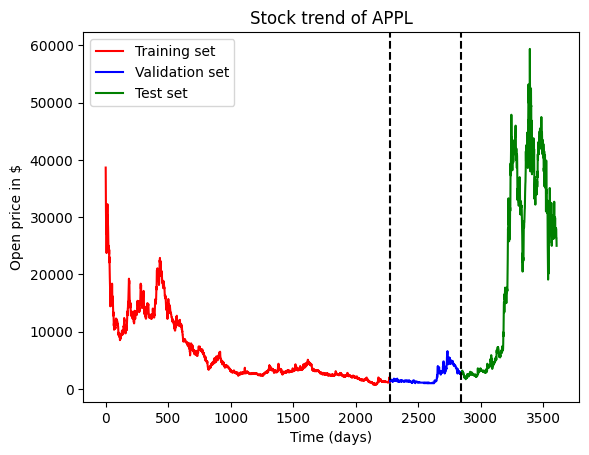

In [345]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(df, window_size)
visualize_train_val_test(X_train, X_val, X_test)

In [346]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_train_norm, y_train_norm = MinMax_normalize(X_train, y_train)
X_val_norm, y_val_norm = MinMax_normalize(X_val, y_val)
X_test_norm, y_test_norm = MinMax_normalize(X_test, y_test)

### 1.1.1 Bi-LSTM model

In [347]:
BiLSTM_history = BiLSTM_model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=epochs, batch_size=batch_size)

Epoch 1/150
2/2 [==============================] - 7s 768ms/step - loss: 0.1384 - mse: 0.1384 - val_loss: 0.1287 - val_mse: 0.1287
Epoch 2/150
2/2 [==============================] - 0s 43ms/step - loss: 0.1041 - mse: 0.1041 - val_loss: 0.1653 - val_mse: 0.1653
Epoch 3/150
2/2 [==============================] - 0s 42ms/step - loss: 0.1359 - mse: 0.1359 - val_loss: 0.1178 - val_mse: 0.1178
Epoch 4/150
2/2 [==============================] - 0s 48ms/step - loss: 0.0935 - mse: 0.0935 - val_loss: 0.1184 - val_mse: 0.1184
Epoch 5/150
2/2 [==============================] - 0s 39ms/step - loss: 0.0928 - mse: 0.0928 - val_loss: 0.1153 - val_mse: 0.1153
Epoch 6/150
2/2 [==============================] - 0s 40ms/step - loss: 0.0881 - mse: 0.0881 - val_loss: 0.1144 - val_mse: 0.1144
Epoch 7/150
2/2 [==============================] - 0s 40ms/step - loss: 0.0856 - mse: 0.0856 - val_loss: 0.1040 - val_mse: 0.1040
Epoch 8/150
2/2 [==============================] - 0s 41ms/step - loss: 0.0759 - mse: 0.0

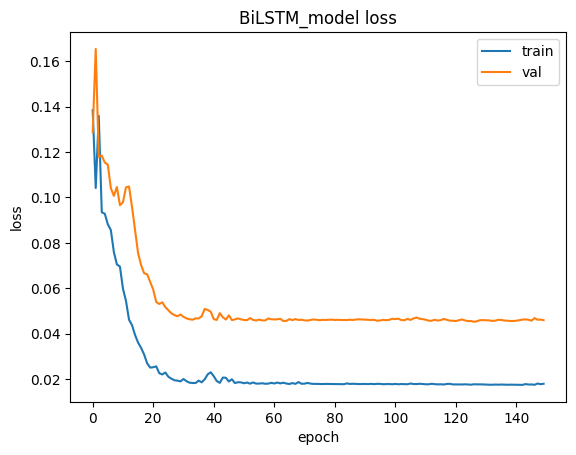

In [348]:
# Visualize the training and validation loss over epochs
plt.plot(BiLSTM_history.history['loss'])
plt.plot(BiLSTM_history.history['val_loss'])
plt.title('BiLSTM_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

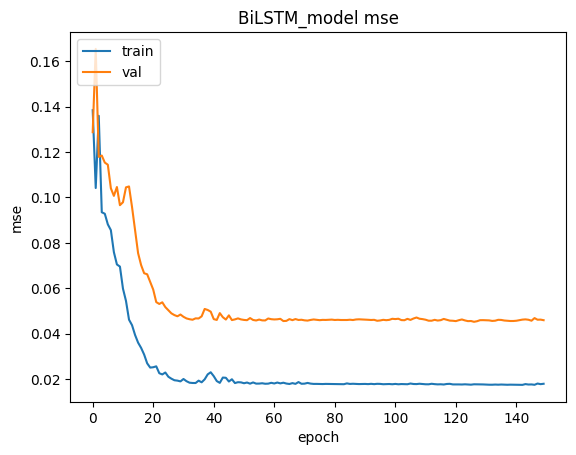

In [349]:
# Visualize the training and validation accuracy over epochs
plt.plot(BiLSTM_history.history['mse'])
plt.plot(BiLSTM_history.history['val_mse'])
plt.title('BiLSTM_model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [350]:
# Get prediction on the test data
y_pred_norm = BiLSTM_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

23/23 [==============================] - 1s 4ms/step
MSE on the test set:  0.015731054539230772


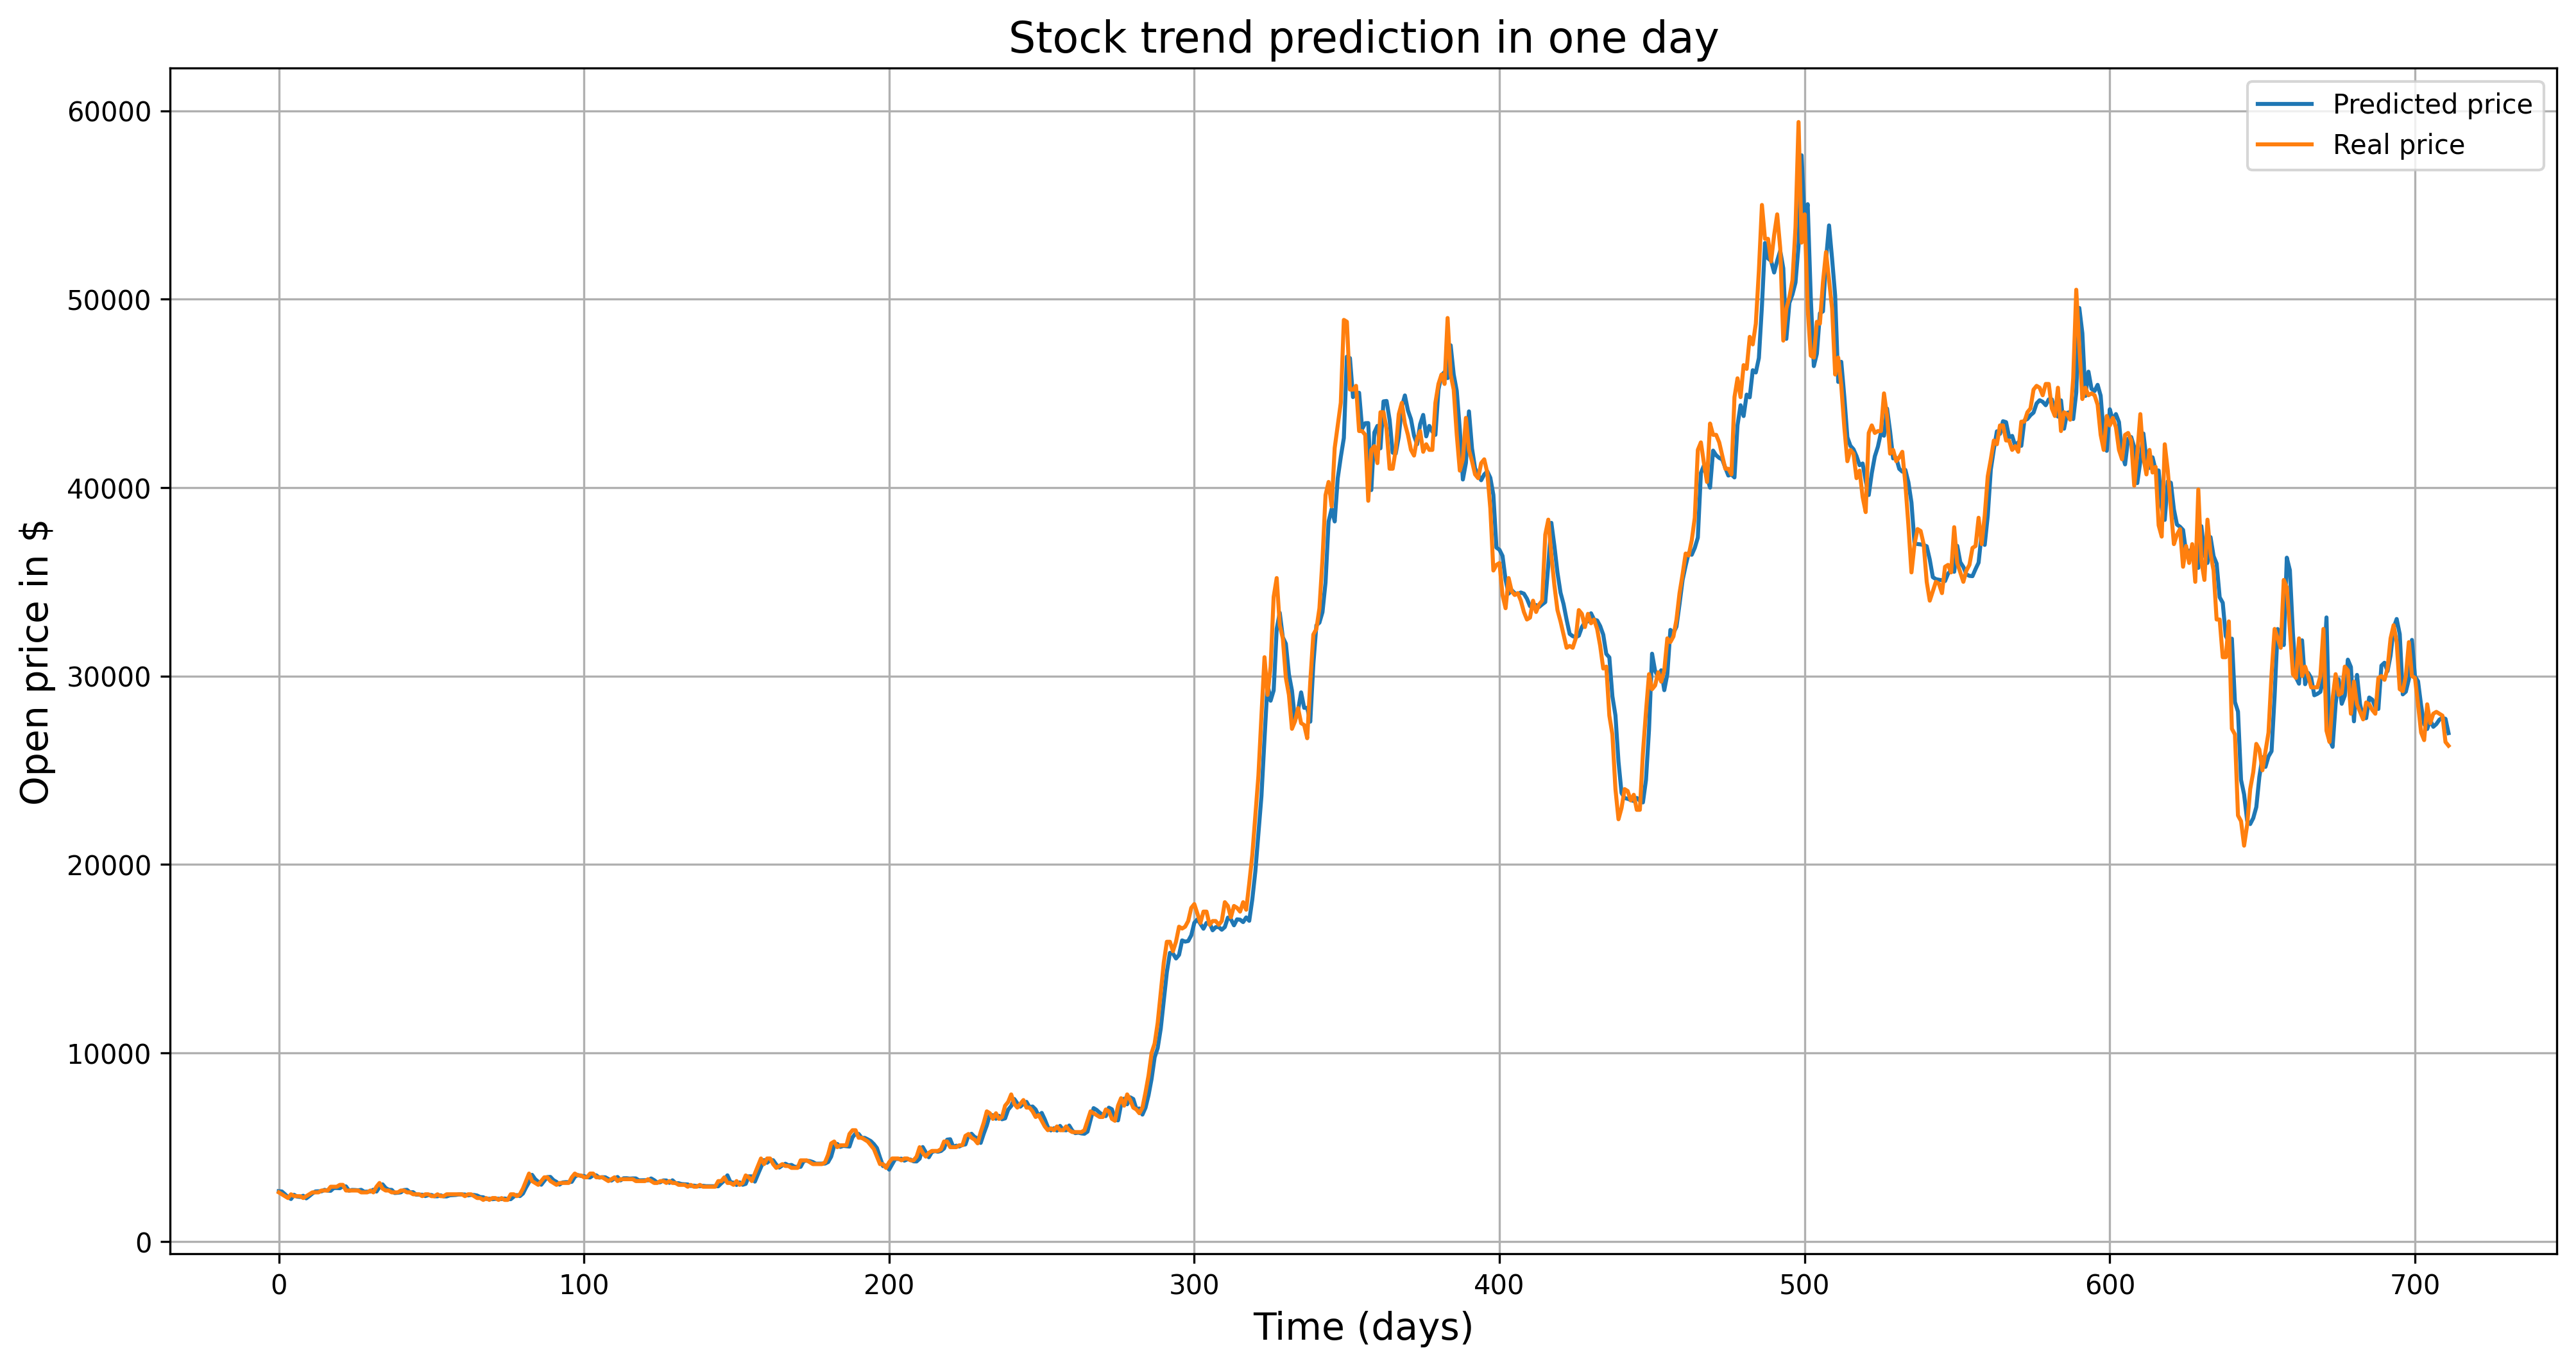

In [351]:
pred_real_visualize(y_pred_norm, X_test, y_test)

### 1.1.2 GRU model

In [352]:
GRU_history = GRU_model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=epochs, batch_size=batch_size)

Epoch 1/150
2/2 [==============================] - 6s 663ms/step - loss: 0.1335 - mse: 0.1335 - val_loss: 0.1207 - val_mse: 0.1207
Epoch 2/150
2/2 [==============================] - 0s 41ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0973 - val_mse: 0.0973
Epoch 3/150
2/2 [==============================] - 0s 44ms/step - loss: 0.0715 - mse: 0.0715 - val_loss: 0.0964 - val_mse: 0.0964
Epoch 4/150
2/2 [==============================] - 0s 41ms/step - loss: 0.0649 - mse: 0.0649 - val_loss: 0.0818 - val_mse: 0.0818
Epoch 5/150
2/2 [==============================] - 0s 54ms/step - loss: 0.0508 - mse: 0.0508 - val_loss: 0.0895 - val_mse: 0.0895
Epoch 6/150
2/2 [==============================] - 0s 40ms/step - loss: 0.0430 - mse: 0.0430 - val_loss: 0.0717 - val_mse: 0.0717
Epoch 7/150
2/2 [==============================] - 0s 38ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0590 - val_mse: 0.0590
Epoch 8/150
2/2 [==============================] - 0s 40ms/step - loss: 0.0311 - mse: 0.0

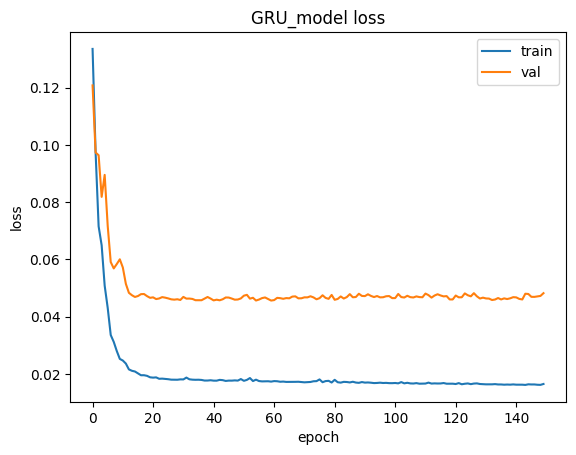

In [353]:
# Visualize the training and validation loss over epochs
plt.plot(GRU_history.history['loss'])
plt.plot(GRU_history.history['val_loss'])
plt.title('GRU_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

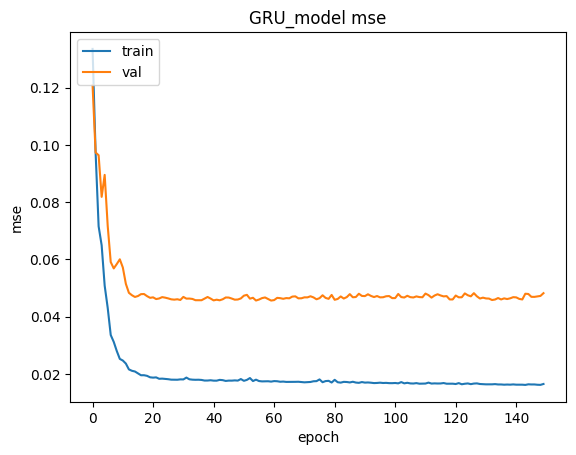

In [354]:
# Visualize the training and validation accuracy over epochs
plt.plot(GRU_history.history['mse'])
plt.plot(GRU_history.history['val_mse'])
plt.title('GRU_model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [355]:
# Get prediction on the test data
y_pred_norm = GRU_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

23/23 [==============================] - 1s 4ms/step
MSE on the test set:  0.014738583694103514


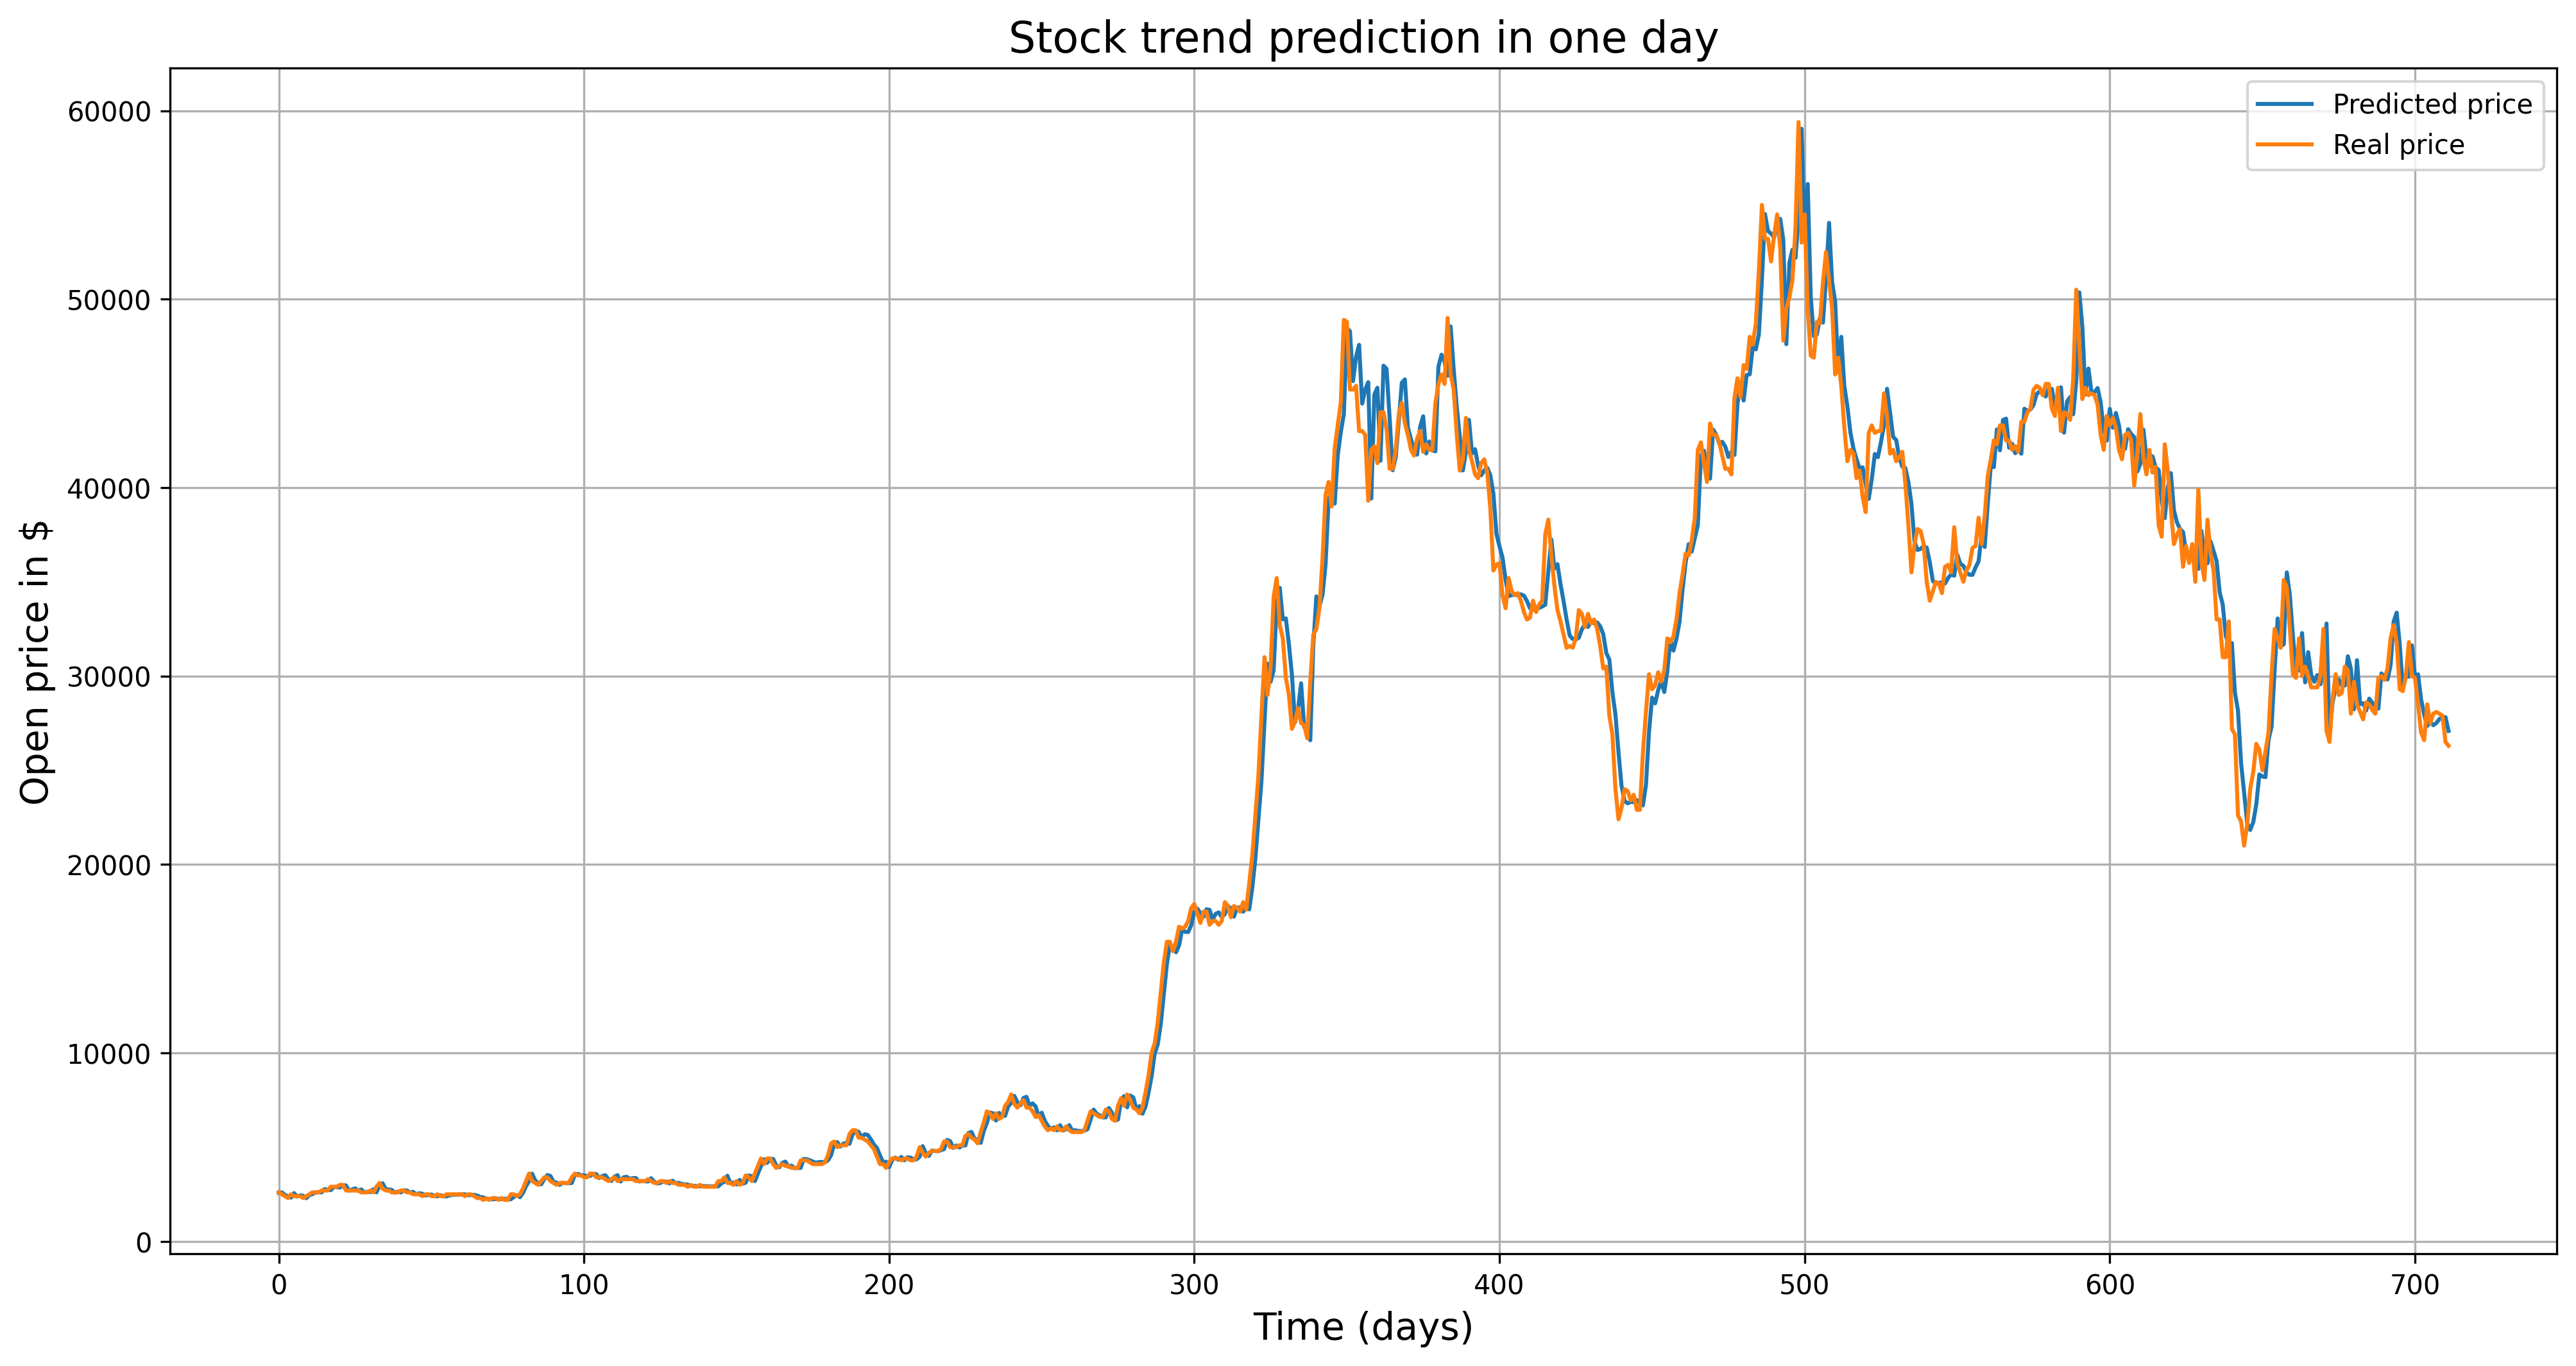

In [356]:
pred_real_visualize(y_pred_norm, X_test, y_test)

### 1.1.3 Conv1D model

In [357]:
Conv1D_history = Conv1D_model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=epochs, batch_size=batch_size)

Epoch 1/150
2/2 [==============================] - 2s 247ms/step - loss: 0.1407 - mse: 0.1407 - val_loss: 0.1491 - val_mse: 0.1491
Epoch 2/150
2/2 [==============================] - 0s 59ms/step - loss: 0.1259 - mse: 0.1259 - val_loss: 0.1399 - val_mse: 0.1399
Epoch 3/150
2/2 [==============================] - 0s 57ms/step - loss: 0.1169 - mse: 0.1169 - val_loss: 0.1362 - val_mse: 0.1362
Epoch 4/150
2/2 [==============================] - 0s 54ms/step - loss: 0.1143 - mse: 0.1143 - val_loss: 0.1386 - val_mse: 0.1386
Epoch 5/150
2/2 [==============================] - 0s 56ms/step - loss: 0.1168 - mse: 0.1168 - val_loss: 0.1389 - val_mse: 0.1389
Epoch 6/150
2/2 [==============================] - 0s 39ms/step - loss: 0.1169 - mse: 0.1169 - val_loss: 0.1371 - val_mse: 0.1371
Epoch 7/150
2/2 [==============================] - 0s 40ms/step - loss: 0.1149 - mse: 0.1149 - val_loss: 0.1359 - val_mse: 0.1359
Epoch 8/150
2/2 [==============================] - 0s 40ms/step - loss: 0.1136 - mse: 0.1

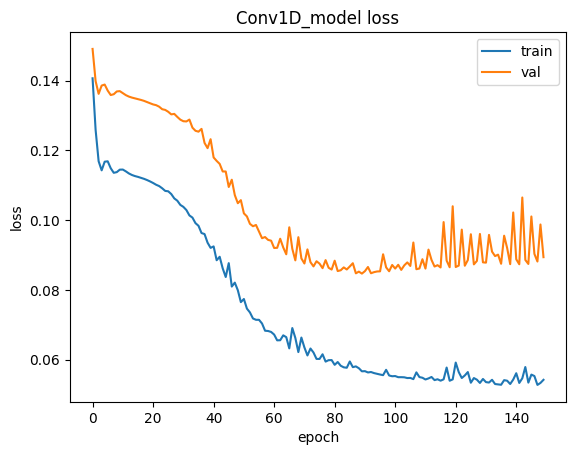

In [358]:
# Visualize the training and validation loss over epochs
plt.plot(Conv1D_history.history['loss'])
plt.plot(Conv1D_history.history['val_loss'])
plt.title('Conv1D_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

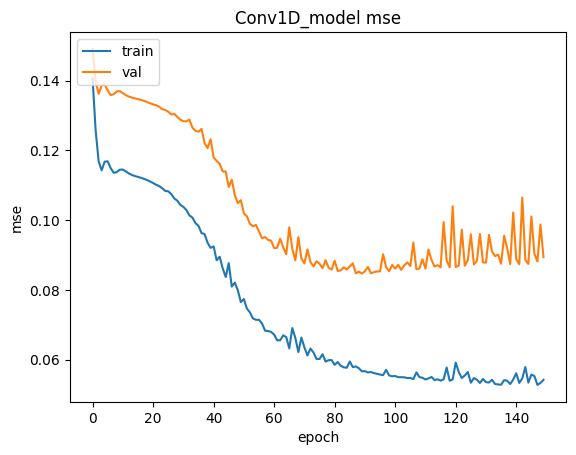

In [359]:
# Visualize the training and validation accuracy over epochs
plt.plot(Conv1D_history.history['mse'])
plt.plot(Conv1D_history.history['val_mse'])
plt.title('Conv1D_model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [360]:
# Get prediction on the test data
y_pred_norm = Conv1D_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

23/23 [==============================] - 0s 2ms/step
MSE on the test set:  0.06906289649226226


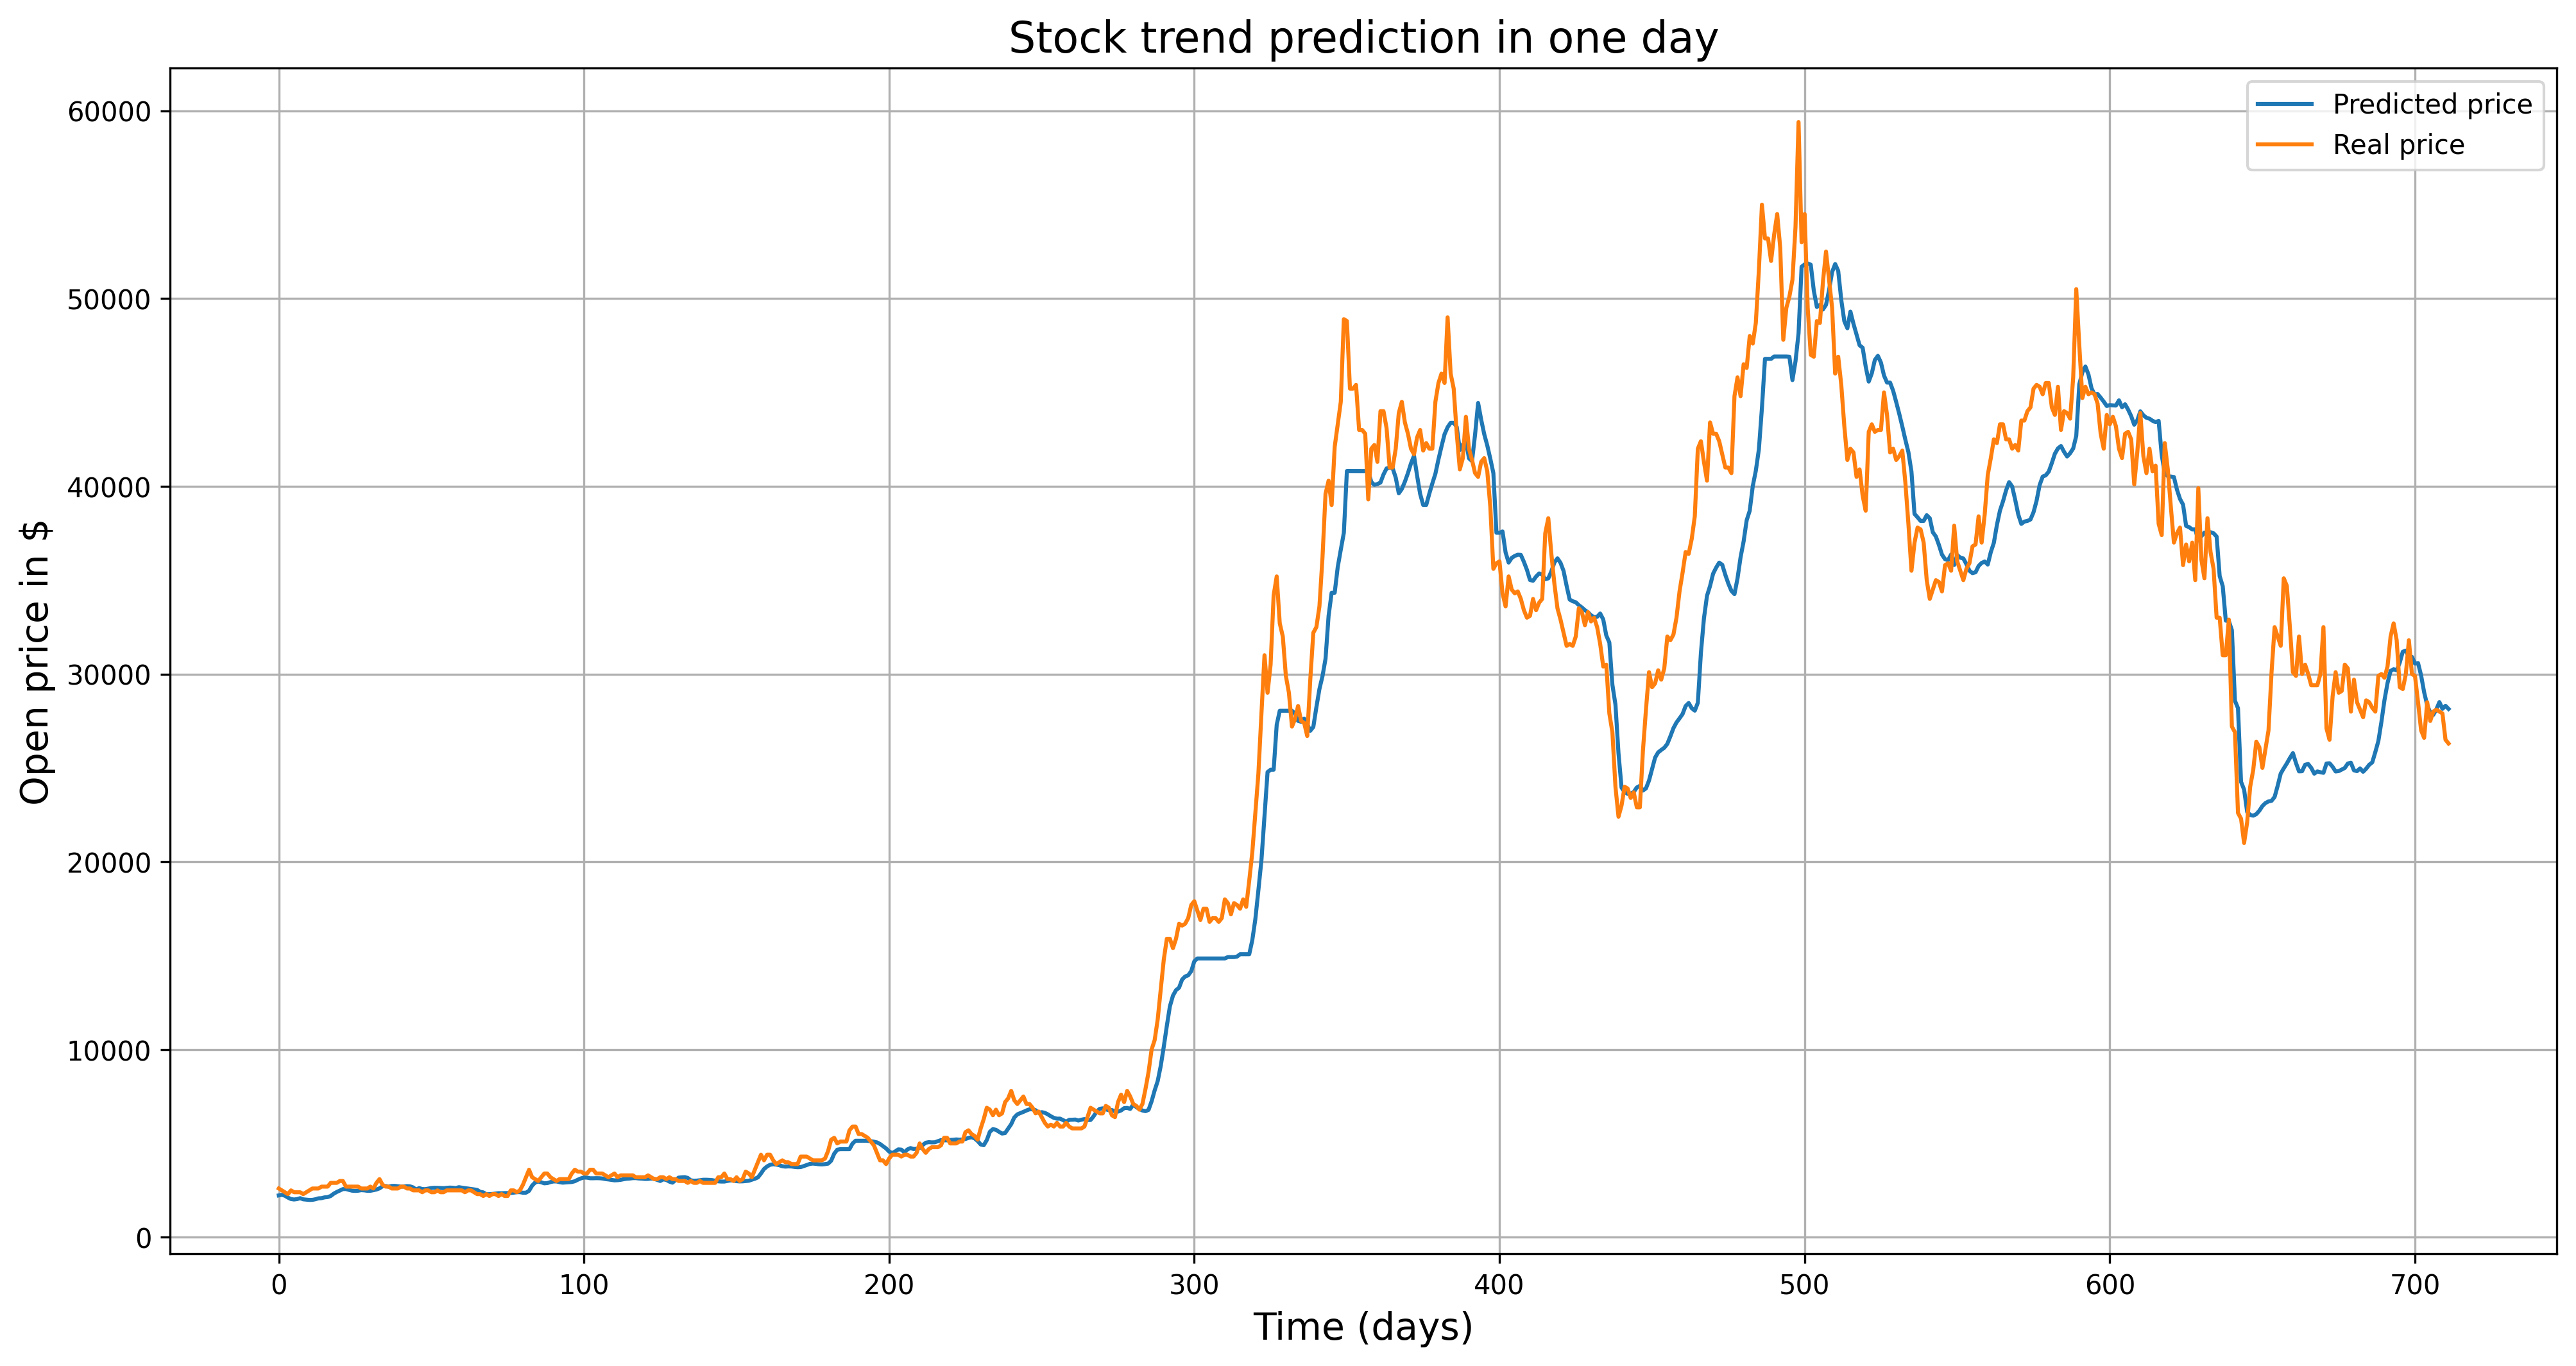

In [361]:
pred_real_visualize(y_pred_norm, X_test, y_test)

## 1.2 CROSS VALIDATION

In [362]:
X_data, y_data = preprocess_crossval(df)

# # Normalize the data
# X_data_norm, y_data_norm = MinMax_normalize(X_data, y_data)

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=folds)

for train_index, test_index in tscv.split(X_data):
    X_train, X_test = X_data[train_index], X_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    X_train_norm, y_train_norm = MinMax_normalize(X_train, y_train)
    
    X_test_norm, y_test_norm = MinMax_normalize(X_test, y_test)

    # Fit the model to the current training fold
    GRU_model.fit(X_train_norm, y_train_norm, epochs=epochs, batch_size=batch_size)
    
# Get prediction on the test data
y_pred_norm = GRU_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

Epoch 1/150
1/1 [==============================] - 0s 23ms/step - loss: 0.0088 - mse: 0.0088
Epoch 2/150
1/1 [==============================] - 0s 22ms/step - loss: 0.0092 - mse: 0.0092
Epoch 3/150
1/1 [==============================] - 0s 21ms/step - loss: 0.0088 - mse: 0.0088
Epoch 4/150
1/1 [==============================] - 0s 21ms/step - loss: 0.0089 - mse: 0.0089
Epoch 5/150
1/1 [==============================] - 0s 21ms/step - loss: 0.0089 - mse: 0.0089
Epoch 6/150
1/1 [==============================] - 0s 21ms/step - loss: 0.0086 - mse: 0.0086
Epoch 7/150
1/1 [==============================] - 0s 31ms/step - loss: 0.0086 - mse: 0.0086
Epoch 8/150
1/1 [==============================] - 0s 25ms/step - loss: 0.0086 - mse: 0.0086
Epoch 9/150
1/1 [==============================] - 0s 21ms/step - loss: 0.0084 - mse: 0.0084
Epoch 10/150
1/1 [==============================] - 0s 21ms/step - loss: 0.0084 - mse: 0.0084
Epoch 11/150
1/1 [==============================] - 0s 21ms/step - lo

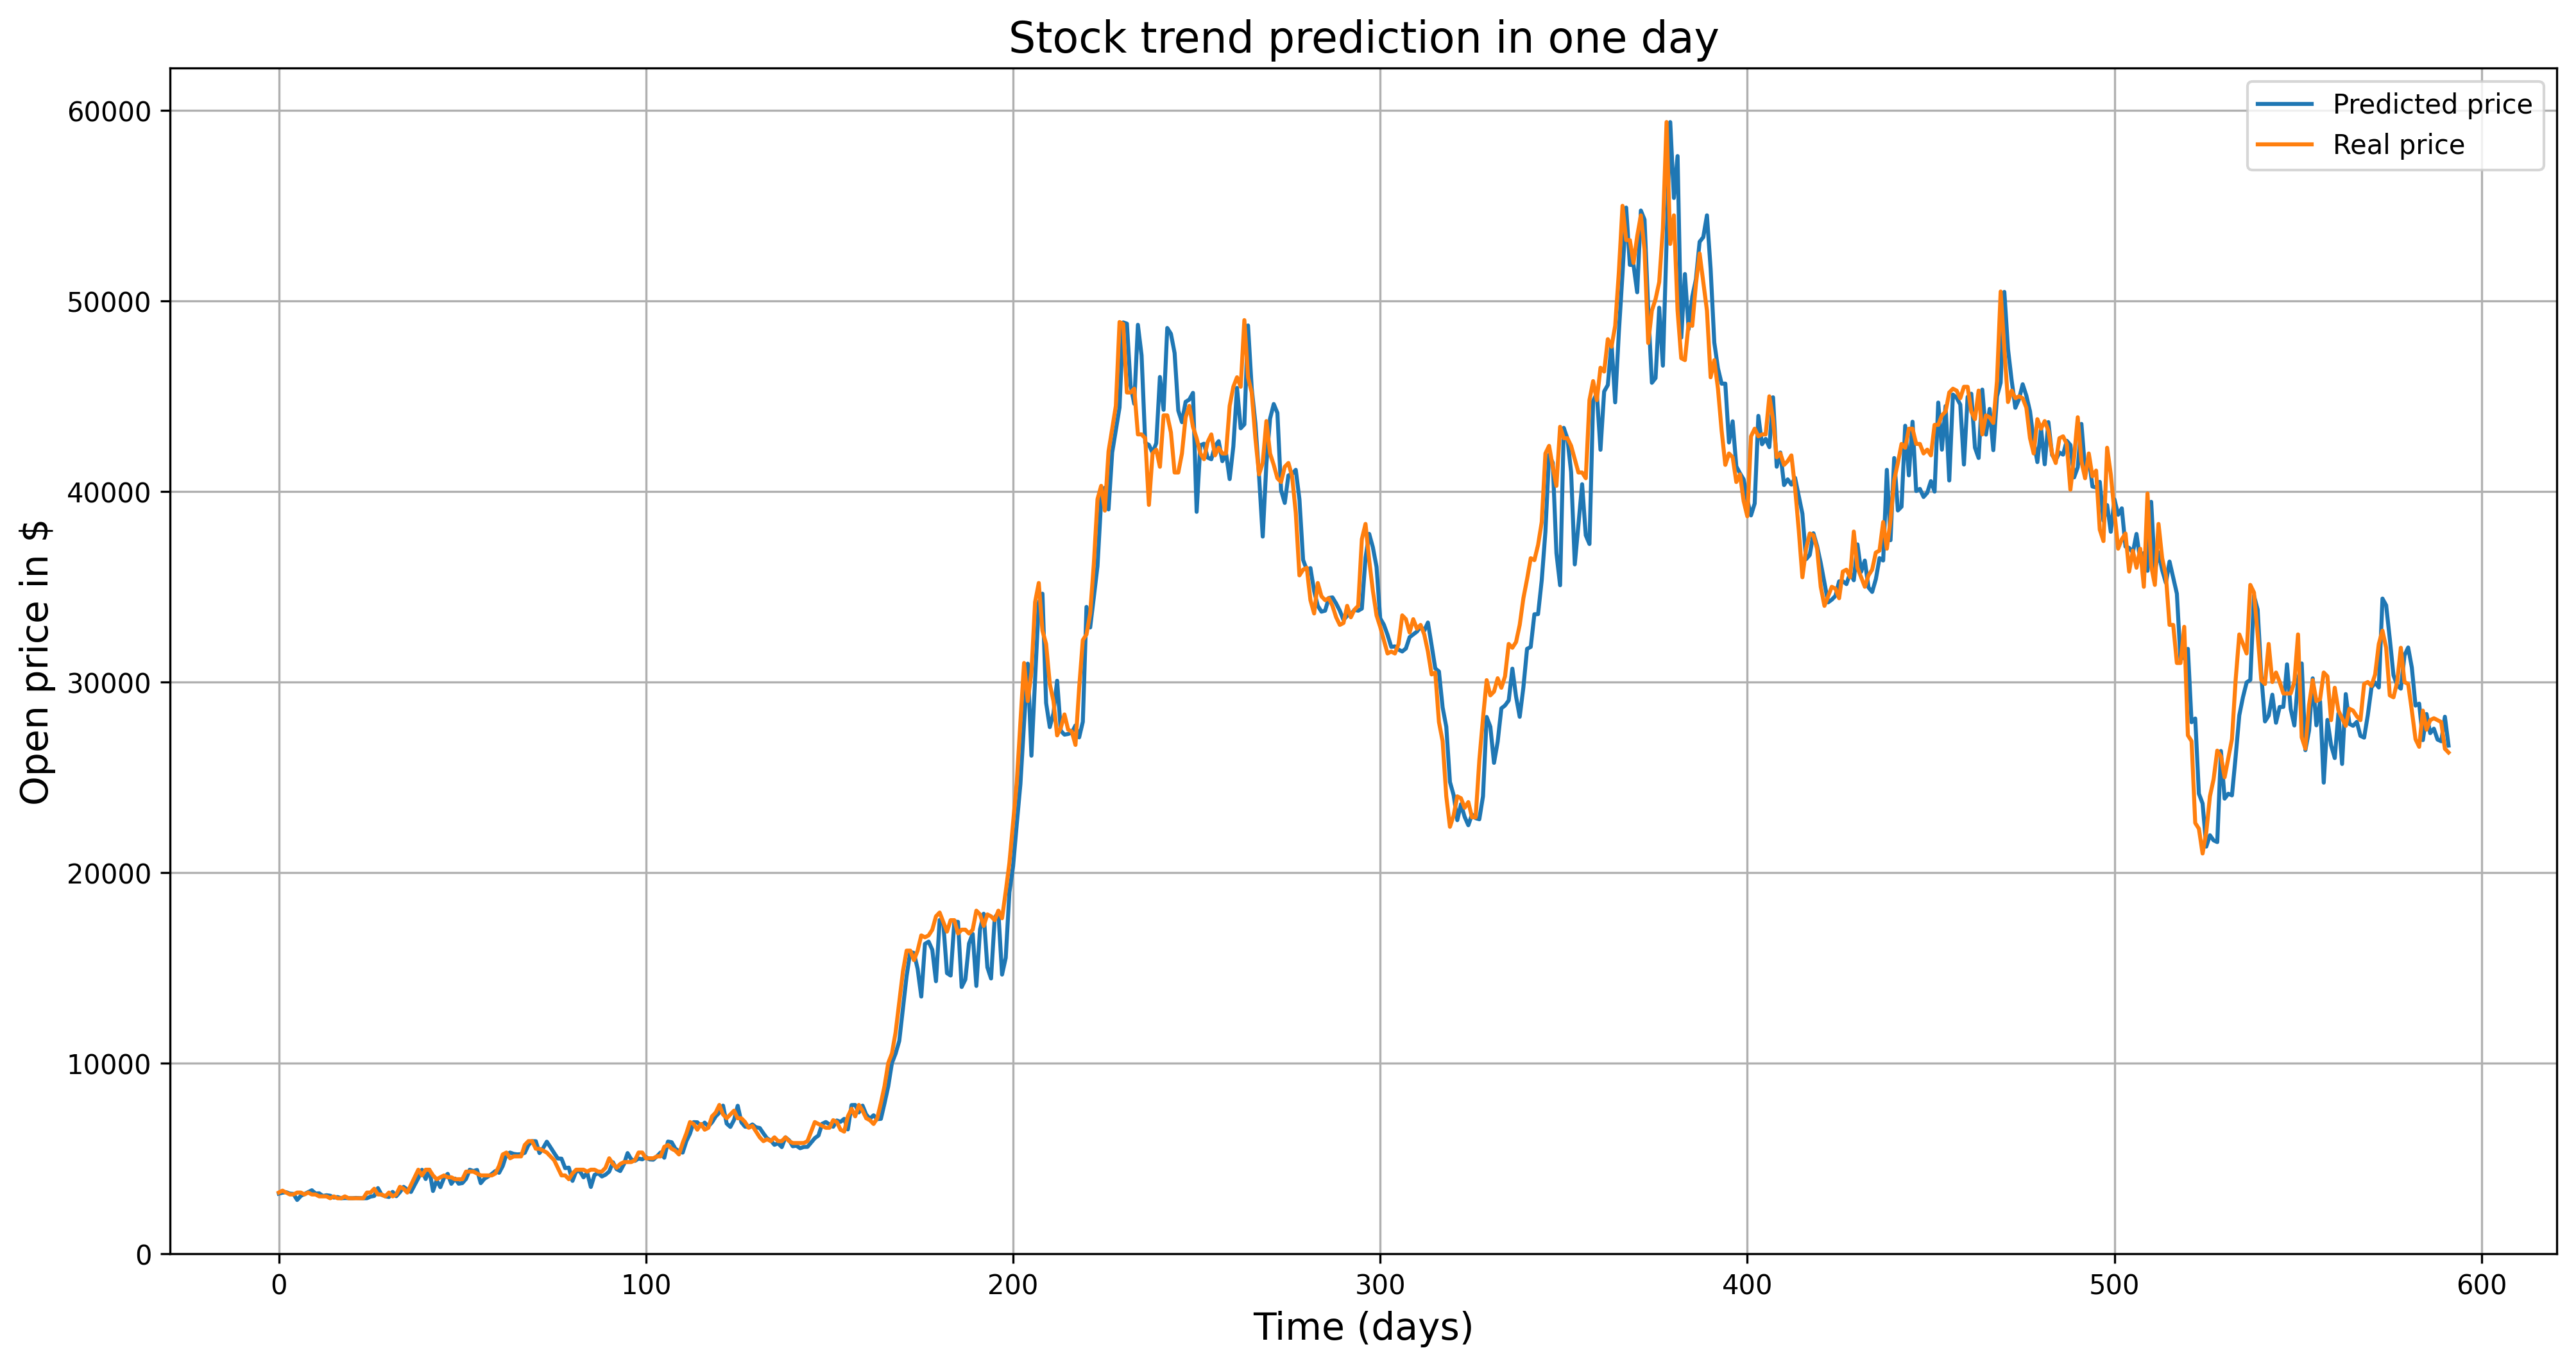

In [363]:
pred_real_visualize(y_pred_norm, X_test, y_test)

# 2. Time windows = 252 days

In [364]:
window_size = 252
epochs = 150
batch_size = 2048
folds = 5

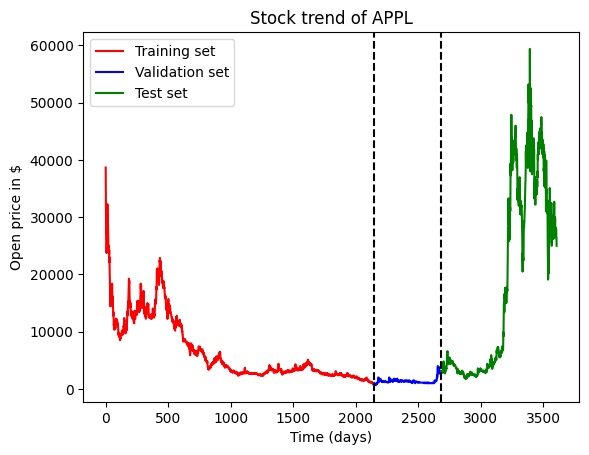

In [365]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(df, window_size)
visualize_train_val_test(X_train, X_val, X_test)

In [366]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_train_norm, y_train_norm = MinMax_normalize(X_train, y_train)
X_val_norm, y_val_norm = MinMax_normalize(X_val, y_val)
X_test_norm, y_test_norm = MinMax_normalize(X_test, y_test)

## 1.1 Training - Validation - Test split

### 1.1.1 Bi-LSTM model

In [367]:
BiLSTM_history = BiLSTM_model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=epochs, batch_size=batch_size)

Epoch 1/150
2/2 [==============================] - 5s 2s/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 2/150
2/2 [==============================] - 0s 62ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 3/150
2/2 [==============================] - 0s 62ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 4/150
2/2 [==============================] - 0s 61ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 5/150
2/2 [==============================] - 0s 64ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 6/150
2/2 [==============================] - 0s 66ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 7/150
2/2 [==============================] - 0s 63ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 8/150
2/2 [==============================] - 0s 70ms/step - loss: 0.0026 - mse: 0.0026

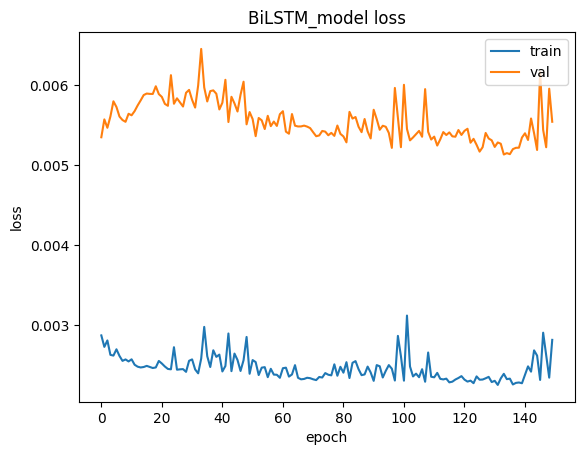

In [368]:
# Visualize the training and validation loss over epochs
plt.plot(BiLSTM_history.history['loss'])
plt.plot(BiLSTM_history.history['val_loss'])
plt.title('BiLSTM_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

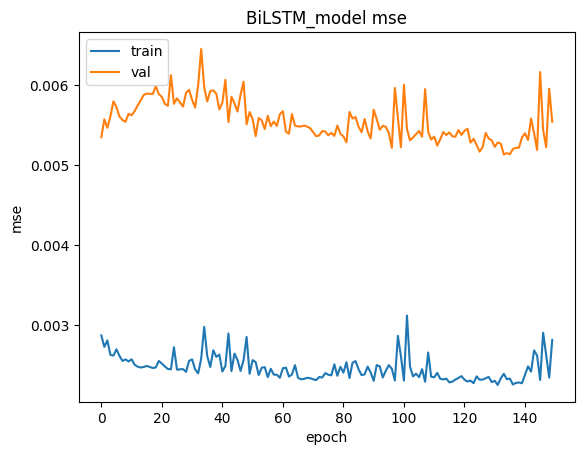

In [369]:
# Visualize the training and validation accuracy over epochs
plt.plot(BiLSTM_history.history['mse'])
plt.plot(BiLSTM_history.history['val_mse'])
plt.title('BiLSTM_model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [370]:
# Get prediction on the test data
y_pred_norm = BiLSTM_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

21/21 [==============================] - 1s 12ms/step
MSE on the test set:  0.0037670002618570802


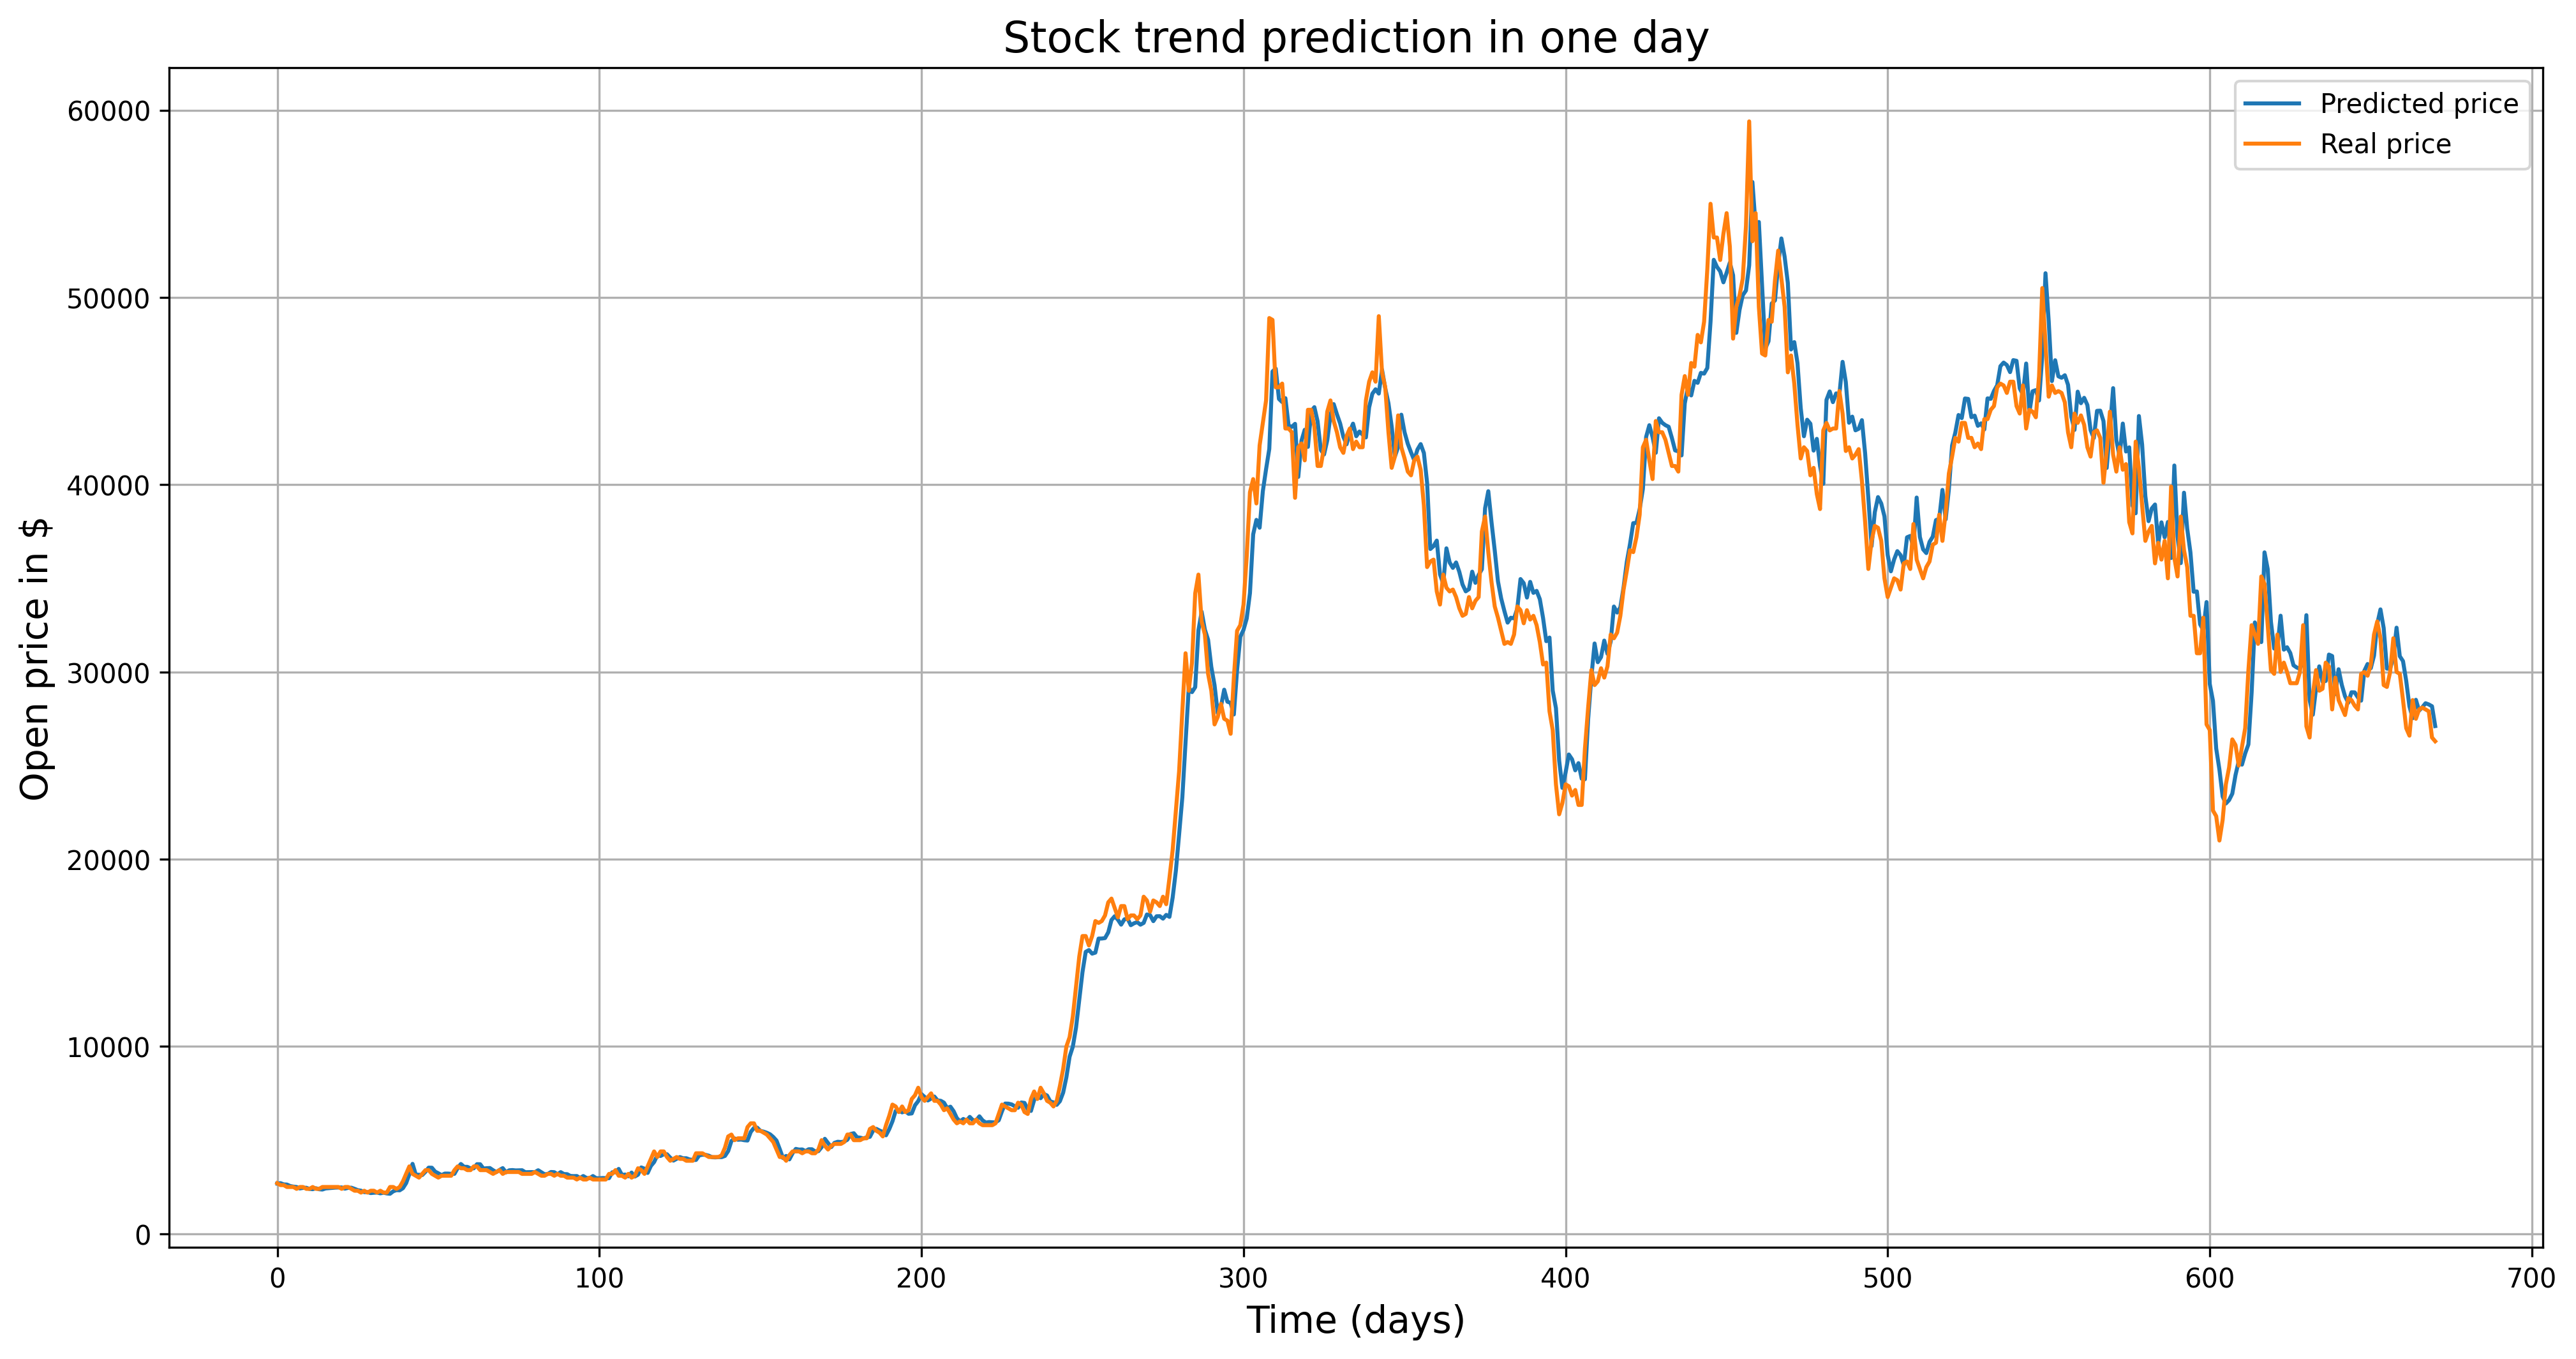

In [371]:
pred_real_visualize(y_pred_norm, X_test, y_test)

### 1.1.2 GRU model

In [372]:
GRU_history = GRU_model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=epochs, batch_size=batch_size)

Epoch 1/150
2/2 [==============================] - 3s 734ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 2/150
2/2 [==============================] - 0s 75ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/150
2/2 [==============================] - 0s 60ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 4/150
2/2 [==============================] - 0s 56ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 5/150
2/2 [==============================] - 0s 59ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 6/150
2/2 [==============================] - 0s 58ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 7/150
2/2 [==============================] - 0s 57ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 8/150
2/2 [==============================] - 0s 58ms/step - loss: 0.0034 - mse: 0.0

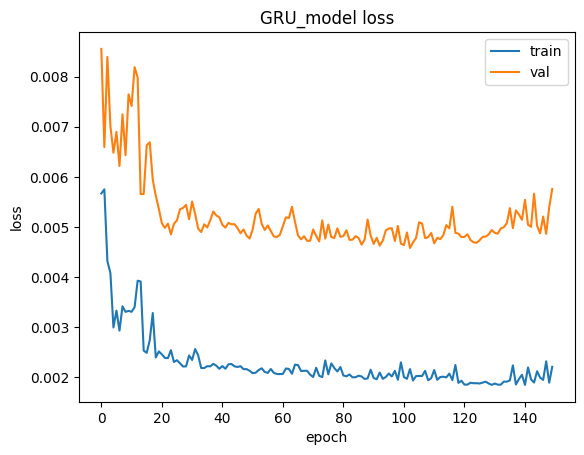

In [373]:
# Visualize the training and validation loss over epochs
plt.plot(GRU_history.history['loss'])
plt.plot(GRU_history.history['val_loss'])
plt.title('GRU_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

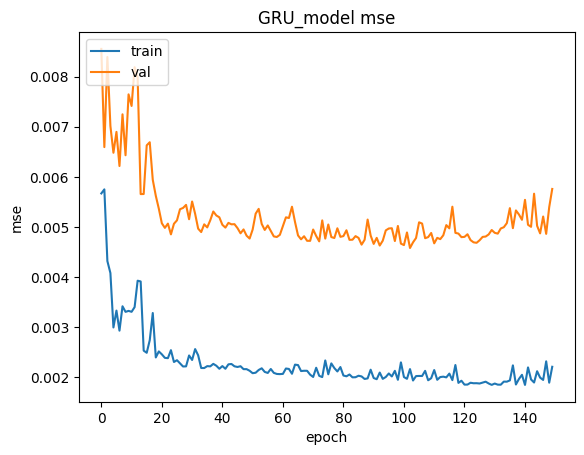

In [374]:
# Visualize the training and validation accuracy over epochs
plt.plot(GRU_history.history['mse'])
plt.plot(GRU_history.history['val_mse'])
plt.title('GRU_model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [375]:
# Get prediction on the test data
y_pred_norm = GRU_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

21/21 [==============================] - 1s 13ms/step
MSE on the test set:  0.003813222757506778


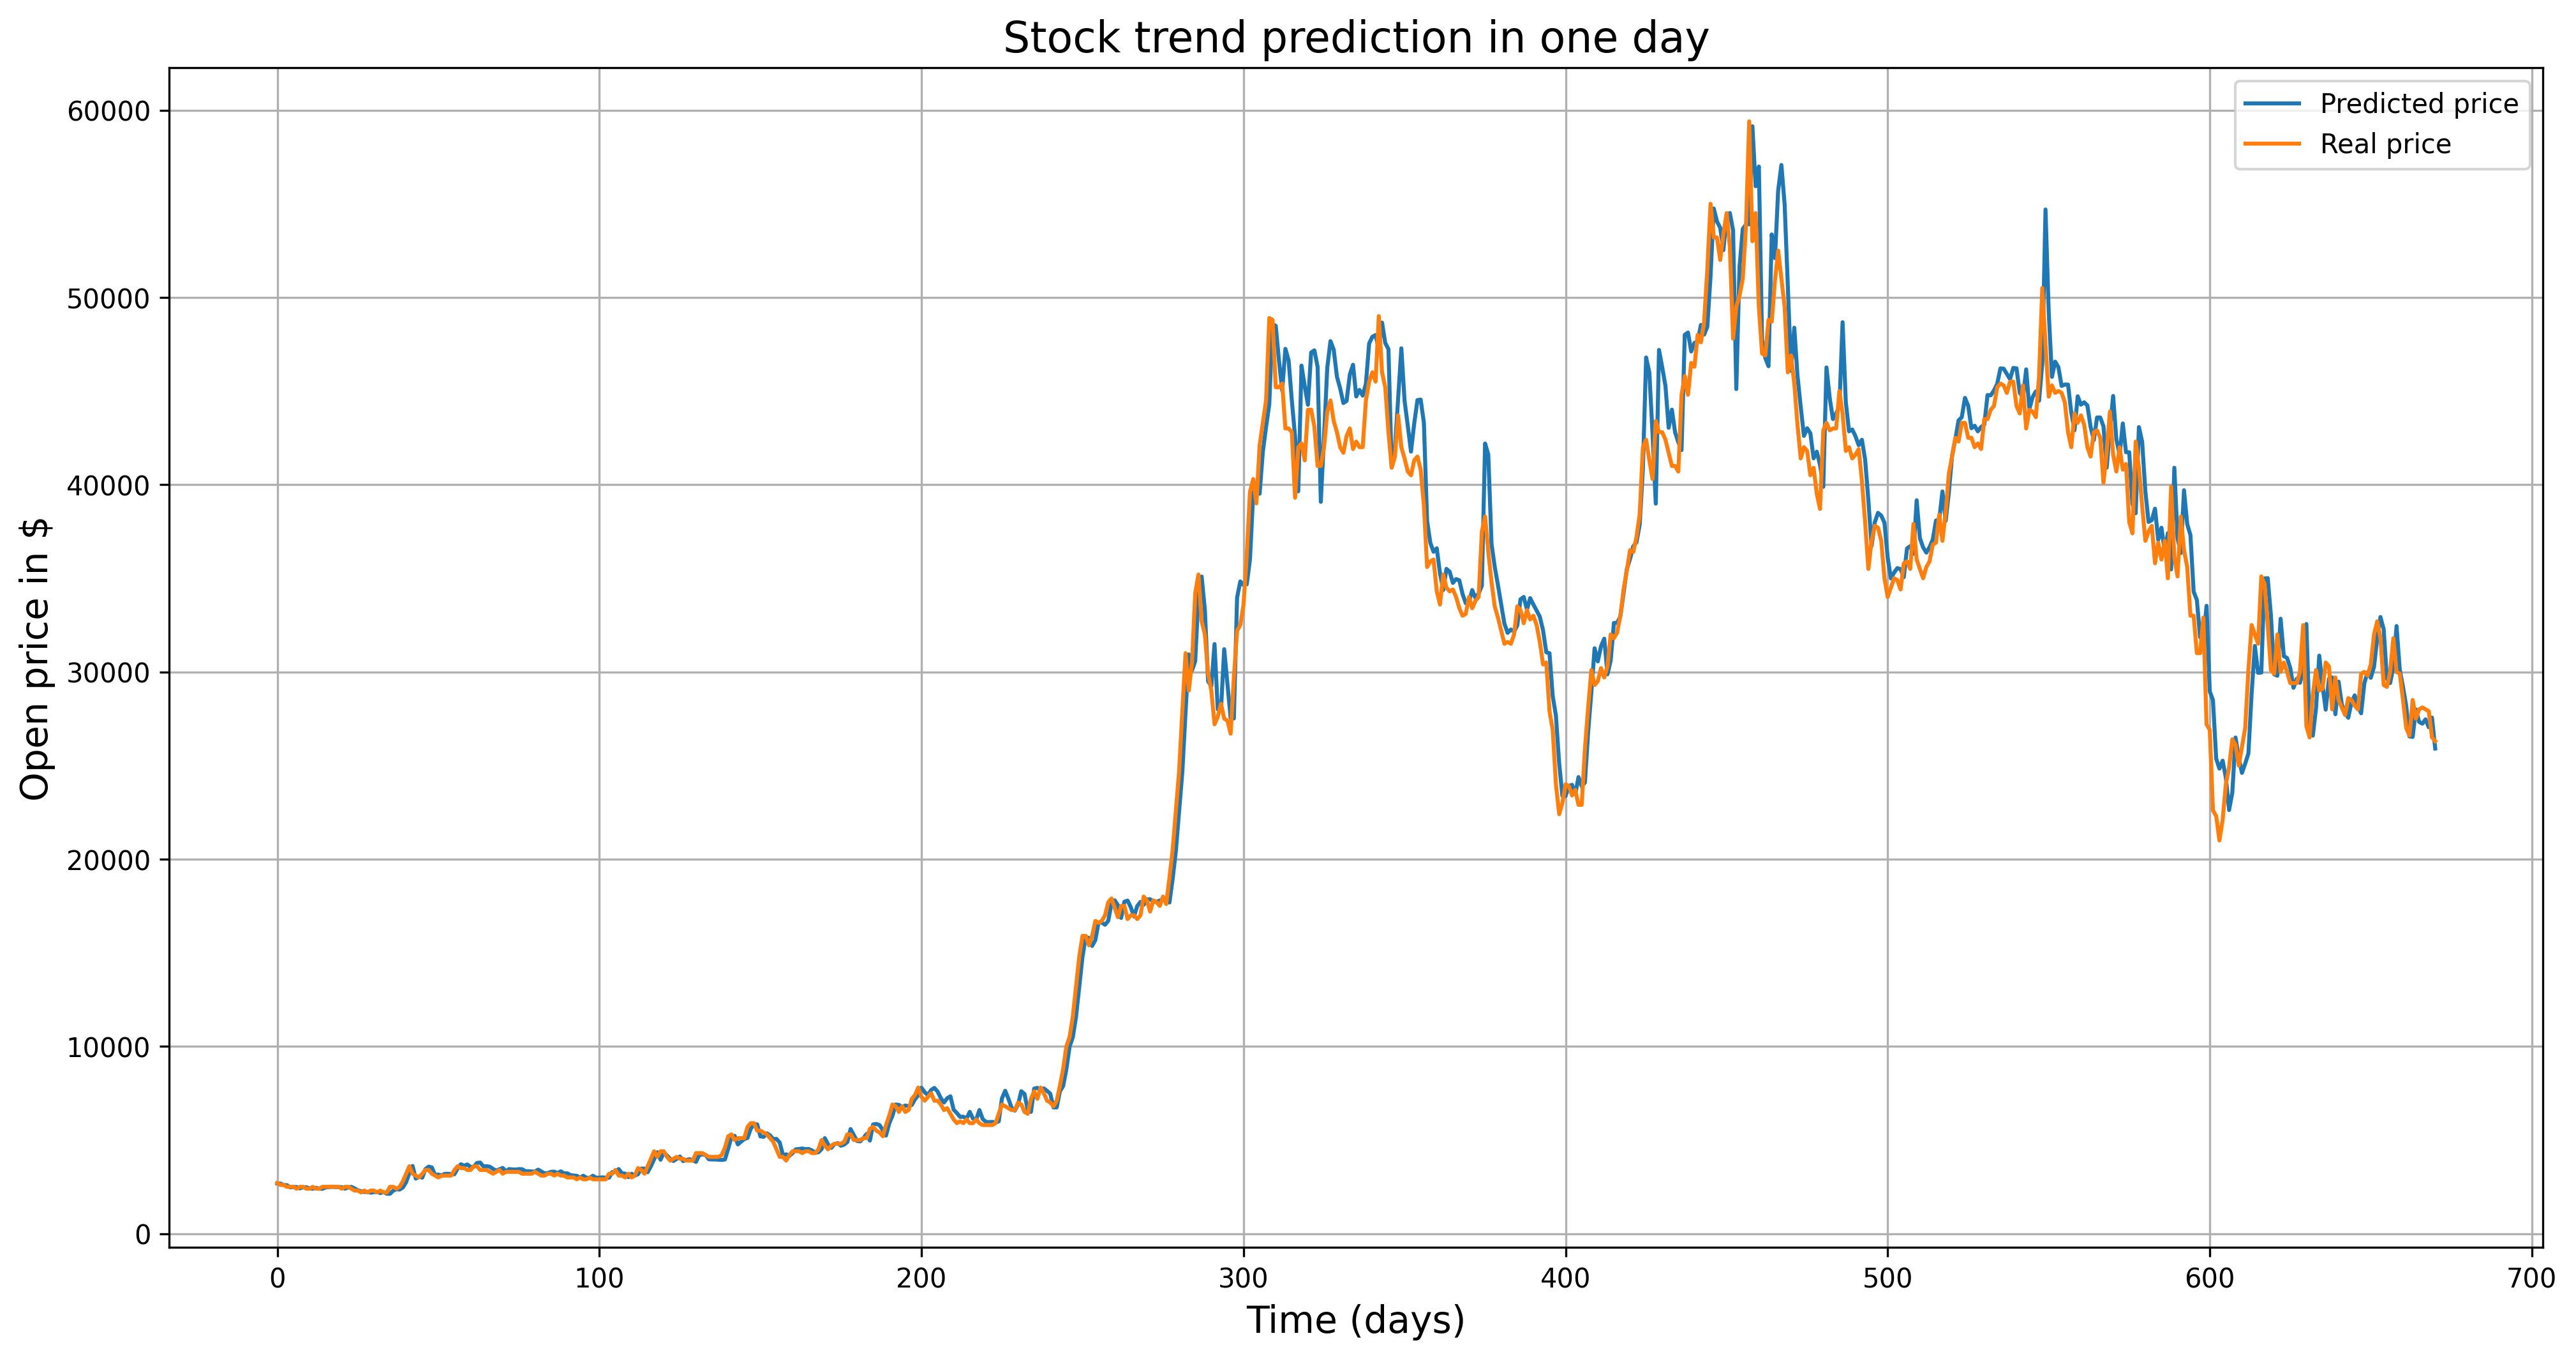

In [376]:
pred_real_visualize(y_pred_norm, X_test, y_test)

### 1.1.3 Conv1D model

In [377]:
Conv1D_history = Conv1D_model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=epochs, batch_size=batch_size)

Epoch 1/150
2/2 [==============================] - 1s 227ms/step - loss: 0.0533 - mse: 0.0533 - val_loss: 0.0997 - val_mse: 0.0997
Epoch 2/150
2/2 [==============================] - 0s 35ms/step - loss: 0.0618 - mse: 0.0618 - val_loss: 0.0900 - val_mse: 0.0900
Epoch 3/150
2/2 [==============================] - 0s 34ms/step - loss: 0.0547 - mse: 0.0547 - val_loss: 0.0923 - val_mse: 0.0923
Epoch 4/150
2/2 [==============================] - 0s 36ms/step - loss: 0.0534 - mse: 0.0534 - val_loss: 0.0972 - val_mse: 0.0972
Epoch 5/150
2/2 [==============================] - 0s 36ms/step - loss: 0.0548 - mse: 0.0548 - val_loss: 0.1066 - val_mse: 0.1066
Epoch 6/150
2/2 [==============================] - 0s 41ms/step - loss: 0.0710 - mse: 0.0710 - val_loss: 0.1080 - val_mse: 0.1080
Epoch 7/150
2/2 [==============================] - 0s 56ms/step - loss: 0.0621 - mse: 0.0621 - val_loss: 0.1059 - val_mse: 0.1059
Epoch 8/150
2/2 [==============================] - 0s 65ms/step - loss: 0.0586 - mse: 0.0

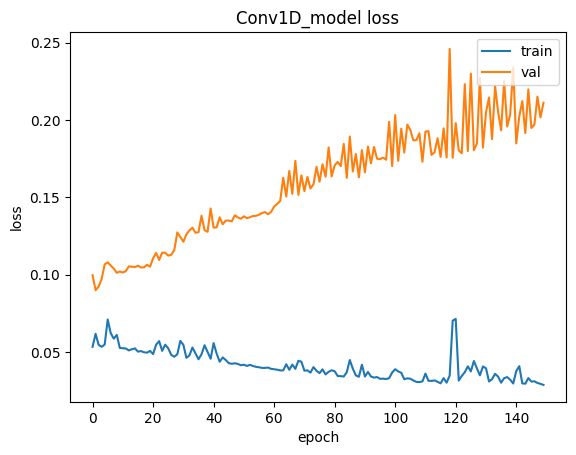

In [378]:
# Visualize the training and validation loss over epochs
plt.plot(Conv1D_history.history['loss'])
plt.plot(Conv1D_history.history['val_loss'])
plt.title('Conv1D_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

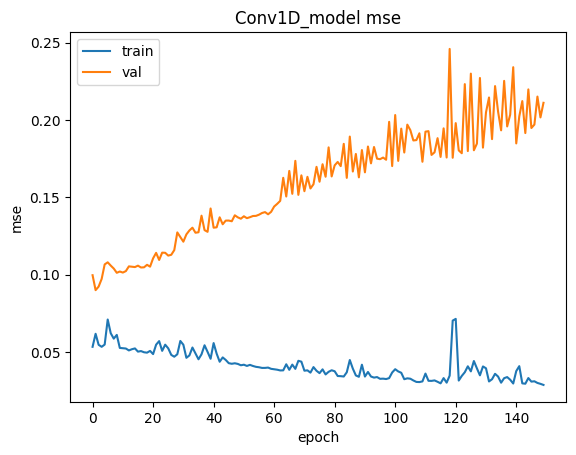

In [379]:
# Visualize the training and validation accuracy over epochs
plt.plot(Conv1D_history.history['mse'])
plt.plot(Conv1D_history.history['val_mse'])
plt.title('Conv1D_model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [380]:
# Get prediction on the test data
y_pred_norm = Conv1D_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

21/21 [==============================] - 0s 2ms/step
MSE on the test set:  0.18575639472141361


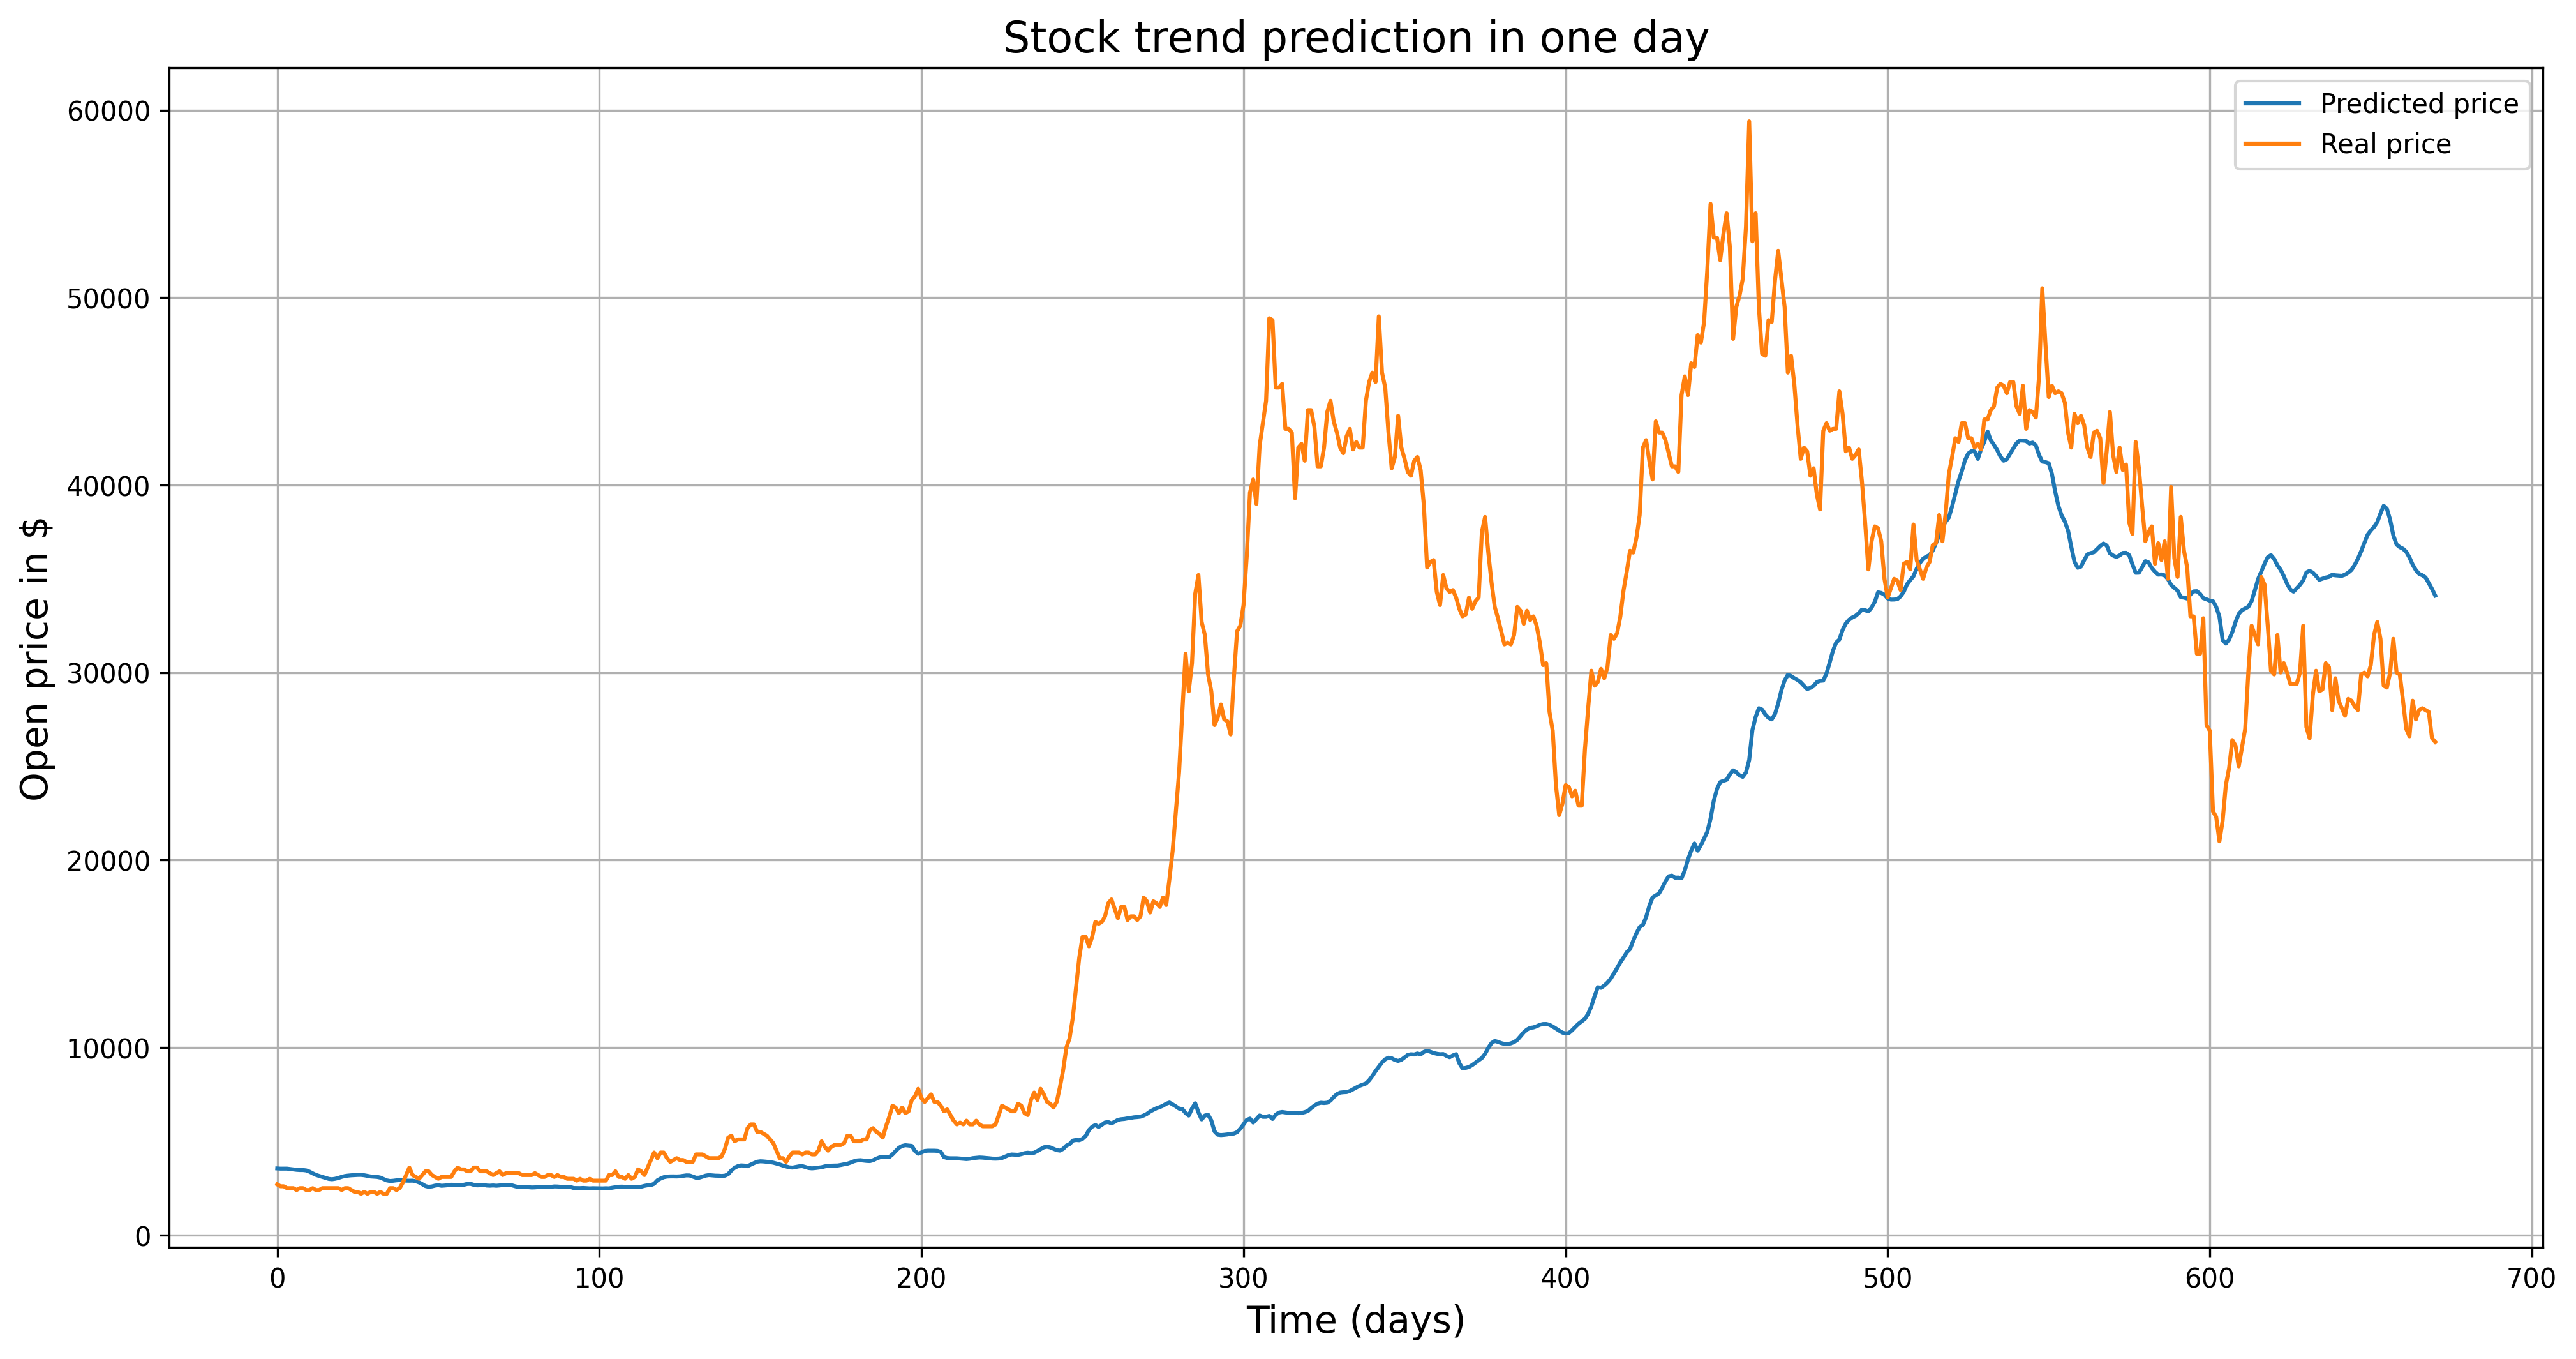

In [381]:
pred_real_visualize(y_pred_norm, X_test, y_test)

## 1.2 CROSS VALIDATION

In [382]:
X_data, y_data = preprocess_crossval(df)

# # Normalize the data
# X_data_norm, y_data_norm = MinMax_normalize(X_data, y_data)

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=folds)

for train_index, test_index in tscv.split(X_data):
    X_train, X_test = X_data[train_index], X_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    X_train_norm, y_train_norm = MinMax_normalize(X_train, y_train)
    
    X_test_norm, y_test_norm = MinMax_normalize(X_test, y_test)

    # Fit the model to the current training fold
    GRU_model.fit(X_train_norm, y_train_norm, epochs=epochs, batch_size=batch_size)
    
# Get prediction on the test data
y_pred_norm = GRU_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

Epoch 1/150
1/1 [==============================] - 0s 66ms/step - loss: 0.0014 - mse: 0.0014
Epoch 2/150
1/1 [==============================] - 0s 61ms/step - loss: 0.0016 - mse: 0.0016
Epoch 3/150
1/1 [==============================] - 0s 61ms/step - loss: 0.0013 - mse: 0.0013
Epoch 4/150
1/1 [==============================] - 0s 48ms/step - loss: 0.0011 - mse: 0.0011
Epoch 5/150
1/1 [==============================] - 0s 44ms/step - loss: 0.0013 - mse: 0.0013
Epoch 6/150
1/1 [==============================] - 0s 47ms/step - loss: 0.0014 - mse: 0.0014
Epoch 7/150
1/1 [==============================] - 0s 45ms/step - loss: 0.0011 - mse: 0.0011
Epoch 8/150
1/1 [==============================] - 0s 39ms/step - loss: 0.0012 - mse: 0.0012
Epoch 9/150
1/1 [==============================] - 0s 36ms/step - loss: 0.0013 - mse: 0.0013
Epoch 10/150
1/1 [==============================] - 0s 37ms/step - loss: 0.0012 - mse: 0.0012
Epoch 11/150
1/1 [==============================] - 0s 35ms/step - lo

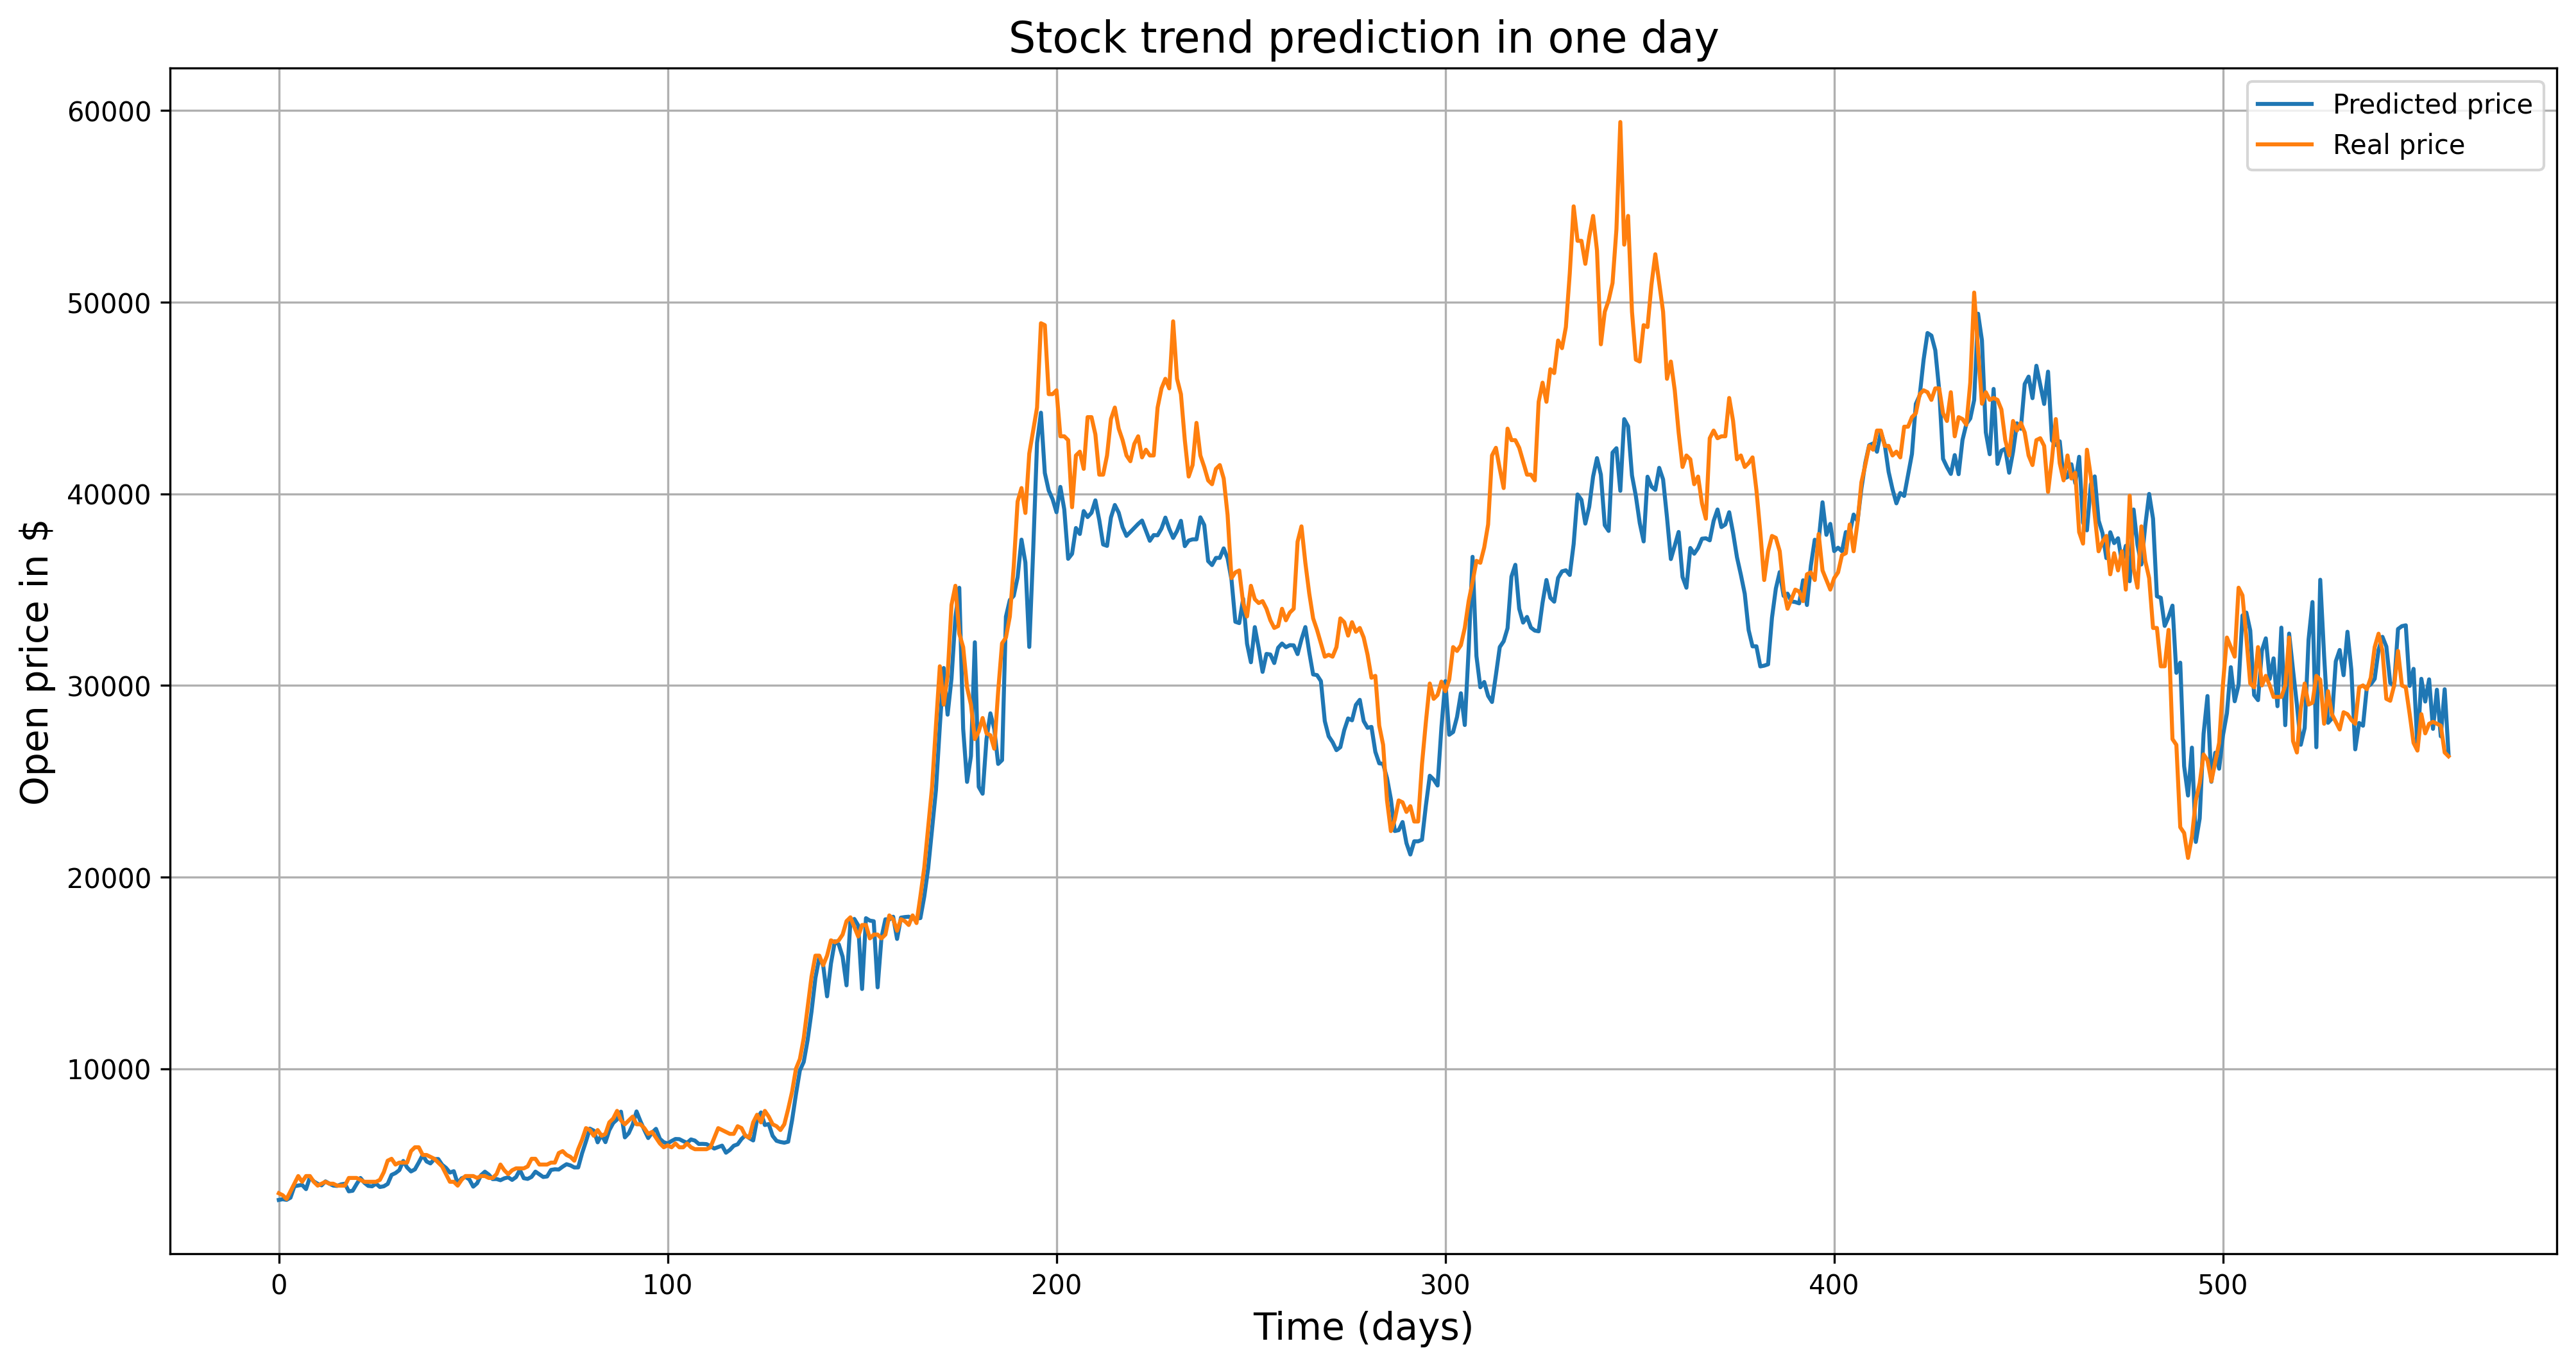

In [383]:
pred_real_visualize(y_pred_norm, X_test, y_test)